In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys

import glob
from datetime import datetime, timedelta
from itertools import combinations
import base64

from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import itertools

# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None


def printm(s): return display(Markdown(s))


In [2]:
## config for various kinds of graphs

gconfigs = {
    'barplot': {'color': 'blue', 'linestyle': '-.', 'marker': '.', 'alpha': 0.5}
}


#Percentile calculations
def perc_75(x): return np.percentile(x, 75)


def perc_25(x): return np.percentile(x, 25)


#Set default RC parameters
notebook_default_rcparams = {
    "axes.titlesize": 32,
    "axes.labelsize": 32,
    "legend.fontsize": 32,
    "legend.title_fontsize": 32,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "axes.grid": True,
    "legend.framealpha": 0.5,
    "lines.linewidth": 5,
    "legend.loc": 'upper left'

}
rcParams.update(notebook_default_rcparams)

# Standardized Labels

EPSILON = 2e-2
#plotting dir


plotting_dir = f'plots_v2/{datetime.now().strftime("%Y%m%d")}'
if not os.path.exists(plotting_dir):
    os.makedirs(plotting_dir)
out_result_dir = f'results_v2/{datetime.now().strftime("%Y%m%d")}'
if not os.path.exists(out_result_dir):
    os.makedirs(out_result_dir)


In [3]:
# Users
users = [f'P{i}' for i in range(1, 11)]

# Config for fetching av results
# loo_k_value = 'loo_equal_v3_0.2_0.05'
# av_loo_prefix = f'av_{loo_k_value}_results'
# av_cache_dir = '/Users/ppatida2/VAX/vax/cache/results_11_11/'
#
# top_k_idxes = range(1, 10)
# av_topk_prefixes = []
# for k_idx in top_k_idxes:
#     av_topk_prefixes.append(f'av_top{k_idx}_equal_v3_0.2_0.05_results')
#
# # Config for fetching privacy results
# # pvs_prefix = 'isl_a0.5_5split_5sample_all1s'
# pvs_prefix = 'smote_v2'
#
# trainer = 'xgbSmote'
# training_results_dir = f'/Users/ppatida2/VAX/vax/cache/privacy_models/training_{pvs_prefix}'
# ensembler = 'score_ensemble'
# ensemble_results_dir = f'/Users/ppatida2/VAX/vax/cache/privacy_models/ensemble_{pvs_prefix}'

# activities
activities = ['NotDetected', 'Baking', 'Blender', 'Chopping+Grating', 'CookingOnStove', 'Coughing',
              'Drinking/Eating', 'Exercising', 'FridgeOpen', 'HairBrush', 'HairDryer', 'HandWash', 'Microwave',
              'Shaver In Use', 'ToiletFlushing', 'Vacuum', 'Walking', 'WashingDishes'
              ]
# activities = ['NotDetected', 'Baking', 'Blender', 'Chopping+Grating', 'CookingOnStove', 'Coughing',
#               'Drinking/Eating', 'Exercising', 'FridgeOpen', 'HairBrush', 'HairDryer', 'HandWash', 'Knocking', 'Microwave',
#               'Shaver In Use', 'ToilerFlushing', 'Vacuum', 'Walking', 'WashingDishes'
#               ]
#
# activities = ['NotDetected', 'Baking', 'Blender', 'Chopping+Grating', 'CookingOnStove', 'Coughing', 'Eating/Drinking',
#               'Exercising', 'FridgeOpen', 'HairBrush', 'HairDryer', 'HandWash', 'Knocking', 'Microwave',
#               'Shaver In Use', 'Talking', 'ToiletFlushing', 'Vacuum', 'Walking', 'WashingDishes'
#               ]

# 'Other', 'Baking', 'Blender', 'Chopping+Grating', 'CookingOnStove', 'Eating/Drinking', 'FridgeOpen', 'Microwave', 'Talking', 'Walking', 'WashingDishes'

# plotting_dir = f'plots/av_{loo_k_value}_pvs_{pvs_prefix}/{datetime.now().strftime("%Y%m%d")}'
# if not os.path.exists(plotting_dir):
#     os.makedirs(plotting_dir)
#
# out_result_dir = f'results/av_{loo_k_value}_pvs_{pvs_prefix}/{datetime.now().strftime("%Y%m%d")}'
# if not os.path.exists(out_result_dir):
#     os.makedirs(out_result_dir)


def best_prediction_combo(pred_score_arr):
    preds = [xr.split("_")[0] for xr in pred_score_arr]
    scores = [float(xr.split("_")[1]) for xr in pred_score_arr]
    df_best_pred = pd.DataFrame(zip(preds, scores), columns=['pred', 'score'])
    df_best_pred = df_best_pred.groupby('pred', as_index=False)['score'].sum().sort_values(by='score', ascending=False)
    return df_best_pred.iloc[0]['pred']

idx_sorted_best_x = pd.Index(['Blender', 'WashingDishes', 'FridgeOpen', 'Drinking/Eating', 'Baking',
       'Chopping+Grating', 'Exercising', 'ToiletFlushing', 'Vacuum', 'Walking',
       'HandWash', 'HairBrush', 'Microwave', 'Coughing', 'Shaver In Use',
       'CookingOnStove', 'HairDryer'])
idx_sorted_best_x

Index(['Blender', 'WashingDishes', 'FridgeOpen', 'Drinking/Eating', 'Baking',
       'Chopping+Grating', 'Exercising', 'ToiletFlushing', 'Vacuum', 'Walking',
       'HandWash', 'HairBrush', 'Microwave', 'Coughing', 'Shaver In Use',
       'CookingOnStove', 'HairDryer'],
      dtype='object')

# 1. Fetch AV and PVS Results

In [15]:
# Fetch AV Results
df_av_results = pd.read_csv('/Users/ppatida2/VAX/vax/cache/av_optics_results/av_pred_0.75_0.9_nn.csv')
df_av_results = df_av_results[['user', 'instance_id', 'groundtruth', 'best_prediction', 'best_score']]
df_av_results.columns = ['user', 'instance', 'gt', 'prediction', 'score']
df_av_results.loc[df_av_results['gt'].isin(['ToilerFlushing']), 'gt'] = 'ToiletFlushing'
df_av_results.loc[df_av_results['prediction'].isin(['ToilerFlushing']), 'prediction'] = 'ToiletFlushing'
# df_av_results
df_av_results.info()
df_av_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user        1054 non-null   object 
 1   instance    1054 non-null   object 
 2   gt          1054 non-null   object 
 3   prediction  1054 non-null   object 
 4   score       1054 non-null   float64
dtypes: float64(1), object(4)
memory usage: 41.3+ KB


,user,instance,gt,prediction,score
0,P1,P1_085,HairBrush,Undetected,0.000000
1,P1,P1_081,HandWash,Shaver In Use,0.754215
2,P1,P1_028,Coughing,Coughing,0.999999
3,P1,P1_029,Coughing,Coughing,0.987253
4,P1,P1_053,HairBrush,Undetected,0.000000


In [16]:
df_av_results['prediction'].unique()

array(['Undetected', 'Shaver In Use', 'Coughing', 'Blender', 'HandWash',
       'Drinking/Eating', 'Walking', 'HairBrush', 'CookingOnStove',
       'Baking', 'Vacuum', 'Exercising', 'Chopping+Grating',
       'ToiletFlushing', 'WashingDishes', 'Microwave', 'FridgeOpen',
       'HairDryer'], dtype=object)

In [73]:
av_top_k_results = {}
for k_idx, k_prefix in zip(top_k_idxes, av_topk_prefixes):
    df_top_av_results = pd.read_csv(f'{av_cache_dir}/{k_prefix}.csv', index_col=0)
    df_top_av_results['user'] = df_top_av_results['instance'].apply(lambda x: x.split("_")[0])
    df_top_av_results.loc[df_top_av_results['gt'].isin(['Chopping', 'Grating']), 'gt'] = 'Chopping+Grating'
    df_top_av_results.loc[
        df_top_av_results['prediction'].isin(['Chopping', 'Grating']), 'prediction'] = 'Chopping+Grating'

    df_top_av_results.loc[df_top_av_results['gt'].isin(['Eating', 'Drinking']), 'gt'] = 'Eating/Drinking'
    df_top_av_results.loc[
        df_top_av_results['prediction'].isin(['Eating', 'Drinking']), 'prediction'] = 'Eating/Drinking'

    df_top_av_results.loc[df_top_av_results['gt'].isin(['ToilerFlushing']), 'gt'] = 'ToiletFlushing'
    df_top_av_results.loc[df_top_av_results['prediction'].isin(['ToilerFlushing']), 'prediction'] = 'ToiletFlushing'
    av_top_k_results[k_idx] = df_top_av_results
    print(f"Got results for top {k_idx} in av")

NameError: name 'top_k_idxes' is not defined

In [74]:
# fetch privacy sensors results
# sensor_results_dict = {}
ensemble_results_dict = {}
for user in users:
    # user_sensor_results_file = f'{training_results_dir}/{user}/{trainer}_sensor_output.pb'
    # if os.path.exists(user_sensor_results_file):
    #     sensor_results_dict[user] = pickle.load(open(user_sensor_results_file,"rb"))
    #     print(f"Got Sensor results for user {user}")
    # else:
    #     print(f"WARNING!!! Unable to get sensor results for user {user}")
    user_ensemble_results_file = f'{ensemble_results_dir}/{user}/{ensembler}_output.pb'
    if os.path.exists(user_ensemble_results_file):
        ensemble_results_dict[user] = pickle.load(open(user_ensemble_results_file, "rb"))
        print(f"Got Ensemble results for user {user}")



NameError: name 'ensemble_results_dir' is not defined

# Evaluation Phase 1: AV

## E1: Participant level accuracy for AV approach

/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/312987583.py:3: RuntimeWarning: invalid value encountered in divide
  conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]


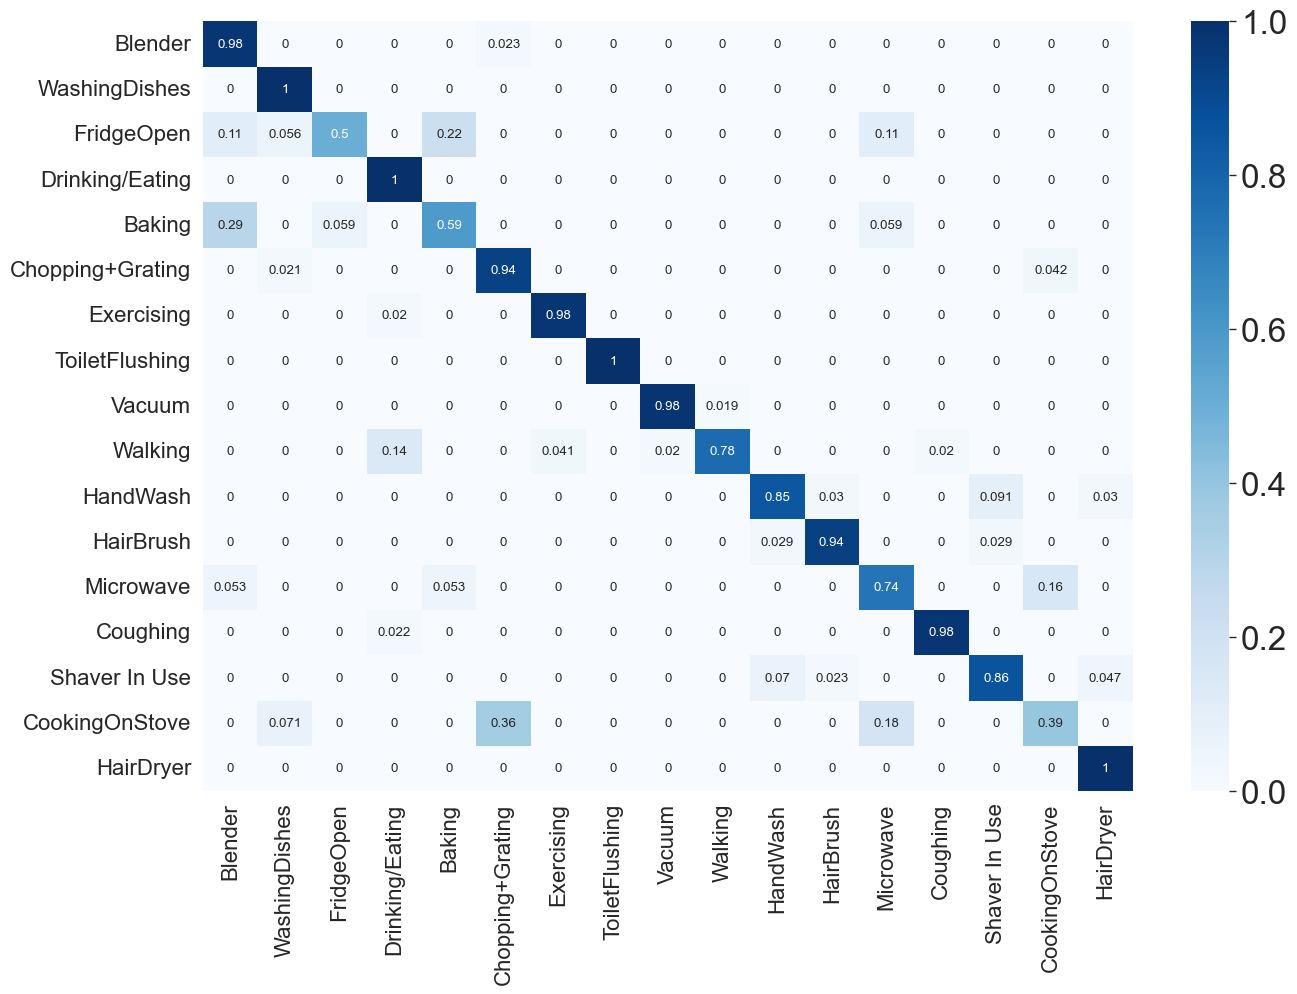

In [17]:
# activity confusion matrix
conf_mat_av = np.round(confusion_matrix(df_av_results['gt'], df_av_results['prediction'], labels=activities),1)
conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]
_ = plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(conf_mat_av[1:, 1:], index=activities[1:], columns=activities[1:]).loc[idx_sorted_best_x,idx_sorted_best_x], annot=True,cmap='Blues')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(f'{plotting_dir}/E1_av_activity_confusion.png', dpi=150, bbox_inches='tight')


In [46]:
conf_mat_av.round(1)

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [0. , 0.6, 0.3, 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2,
        0. , 0. , 0. , 0. , 0.1],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0.1, 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0.1,
        0. , 0. , 0. , 0. , 0.1],
       [0. , 0. , 0. , 0. , 0. , 0. ,

In [12]:
df_av_results[(df_av_results.user=='P1') & (df_av_results['gt']=='Baking')]

,user,instance,gt,prediction,score
40,P1,P1_119,Baking,Undetected,0.0
41,P1,P1_121,Baking,Undetected,0.0
42,P1,P1_120,Baking,Undetected,0.0
43,P1,P1_122,Baking,Undetected,0.0
44,P1,P1_116,Baking,Undetected,0.0


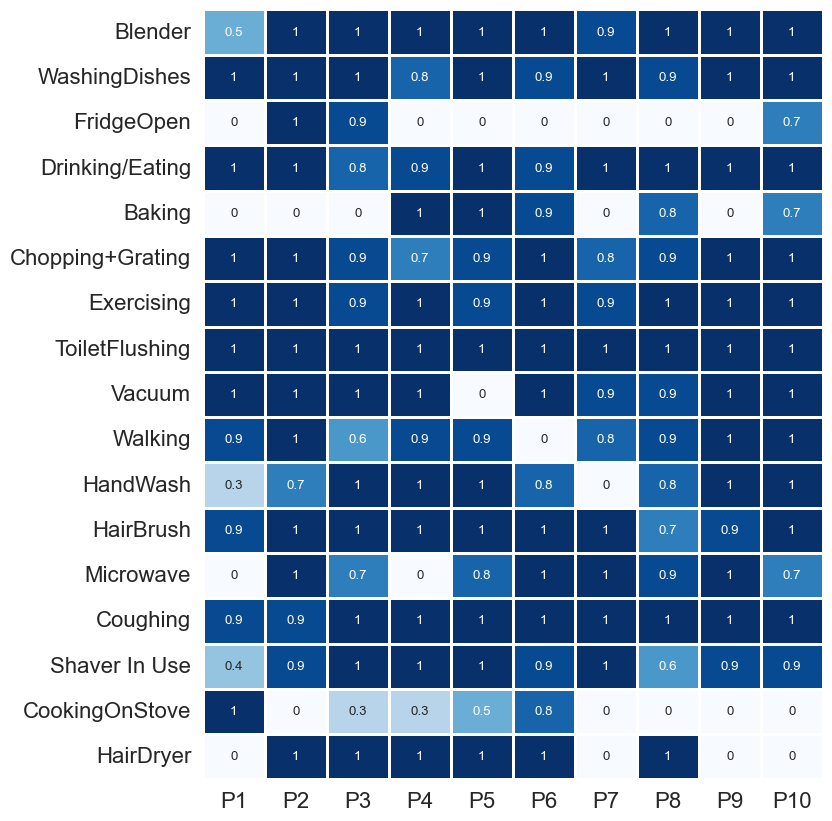

In [18]:
# participant activity precision matrix
user_precision_all = []
user_f1_all = []
user_apr = []
for user in users:
    df_result_users = df_av_results[df_av_results.user == user]
    df_result_users = df_result_users[~(df_result_users.prediction == 'Undetected')]
    user_precision_all.append(
        precision_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=activities,
                        zero_division=0))
    user_f1_all.append(
        f1_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=activities,
                        zero_division=0))
    user_apr.append([
        accuracy_score(df_result_users['gt'], df_result_users['prediction'], ),
        precision_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=activities,
                        zero_division=0),
        recall_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=activities,
                     zero_division=0),
    ])
# df_precision = pd.DataFrame(np.array(user_precision_all).T, columns=users, index=activities)
# _ = plt.figure(figsize=(15, 10))
# sns.heatmap(df_precision.iloc[1:].loc[idx_sorted_best_x], annot=True, linecolor='w', linewidths=1,cmap='Blues')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.savefig(f'{plotting_dir}/E1_participant_activity_precision.png', dpi=150, bbox_inches='tight')

df_f1 = pd.DataFrame(np.array(user_f1_all).T, columns=users, index=activities)
_ = plt.figure(figsize=(8, 10))
sns.heatmap(df_f1.iloc[1:].loc[idx_sorted_best_x].round(1), annot=True, linecolor='w', linewidths=1,cmap='Blues',cbar=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(f'{plotting_dir}/E1_participant_activity_f1.png', dpi=150, bbox_inches='tight')


90.5 89.5 90.5


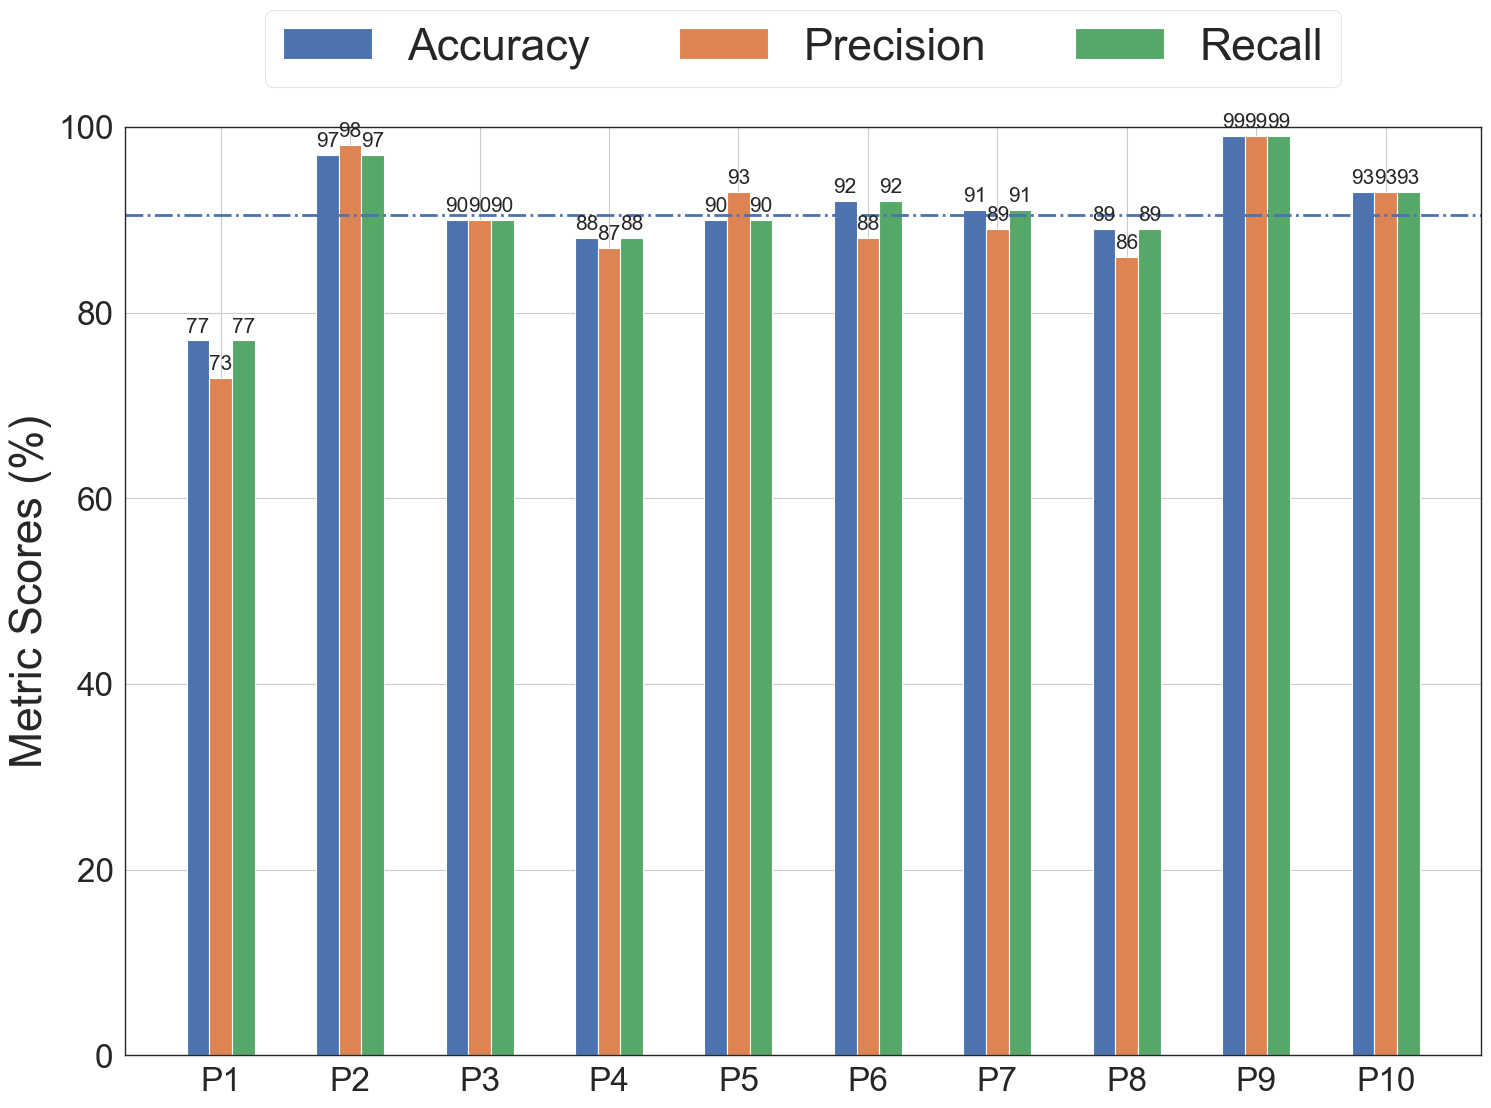

In [19]:
# Final APR matrix at participant level
df_apr = pd.DataFrame(user_apr, columns=['Accuracy', 'Precision', 'Recall'], index=users).round(2) * 100
labels = users
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
rects1 = ax.bar(x - width / 2, df_apr['Accuracy'], width / 2, label='Accuracy')
rects2 = ax.bar(x, df_apr['Precision'], width / 2, label='Precision')
rects3 = ax.bar(x + width / 2, df_apr['Recall'], width / 2, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Scores (%)')
# ax.set_title(f'A/P/R Metrics: {k_value} results')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=15)
ax.bar_label(rects2, padding=3, fontsize=15)
ax.bar_label(rects3, padding=3, fontsize=15)

acc, prec, recall = df_apr.median(axis=0).values
print(acc,prec,recall)
ax.axhline(acc, linestyle='-.', linewidth=2)

fig.tight_layout()
plt.ylim(top=100)
plt.legend(loc='upper center', ncol=3,bbox_to_anchor = [0.5, 1.15])
plt.savefig(f'{plotting_dir}/E1_apr_participants.png', dpi=150, bbox_inches='tight')


In [9]:
plotting_dir

'plots_v2/20230510'

In [16]:
# Accuracy improvement as number of homes increase
k_idx_apr = []
for k_idx in av_top_k_results.keys():
    df_results = av_top_k_results[k_idx]
    user_apr = []
    for user in users[k_idx:]:
        df_result_users = df_results[df_results.user == user]
        df_result_users = df_result_users[~(df_result_users.prediction == 'NotDetected')]
        user_precision_all.append(
            precision_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=activities,
                            zero_division=0))
        user_apr.append([
            accuracy_score(df_result_users['gt'], df_result_users['prediction'], ),
            precision_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=activities,
                            zero_division=0),
            recall_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=activities,
                         zero_division=0),
        ])
    k_idx_apr.append((k_idx, np.mean(np.array(user_apr), axis=0)))

In [17]:
df_topk_av = pd.DataFrame([xr[1] for xr in k_idx_apr], index=[f'P1-P{xr[0]}' for xr in k_idx_apr])
df_topk_av.columns = ['Accuracy', 'Precision', 'Recall']

ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
# increase in APR Values as no. of homes increase
df_apr = pd.DataFrame(df_topk_av.values, columns=['Accuracy', 'Precision', 'Recall'], index=df_topk_av.index).round(
    2) * 100
labels = df_topk_av.index
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
rects1 = ax.bar(x - width / 2, df_apr['Accuracy'], width / 2, label='Accuracy')
rects2 = ax.bar(x, df_apr['Precision'], width / 2, label='Precision')
rects3 = ax.bar(x + width / 2, df_apr['Recall'], width / 2, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Scores (%)')
# ax.set_title(f'A/P/R Metrics: {k_value} results')
ax.set_xticks(x, labels)
ax.legend()

#

ax.bar_label(rects1, padding=3, fontsize=15)
ax.bar_label(rects2, padding=3, fontsize=15)
ax.bar_label(rects3, padding=3, fontsize=15)
fig.tight_layout()
plt.ylim(top=100)
plt.savefig(f'{plotting_dir}/E1_apr_homes_increase.png', dpi=150, bbox_inches='tight')


# E2: PVS Evaluation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6734 entries, 0 to 1024
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user         6734 non-null   object 
 1   instance_id  6734 non-null   object 
 2   gt           6734 non-null   object 
 3   av           6734 non-null   object 
 4   prediction   6734 non-null   object 
 5   score        6734 non-null   float64
 6   sensor       6734 non-null   object 
dtypes: float64(1), object(6)
memory usage: 420.9+ KB


/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/1831890631.py:31: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/1831890631.py:31: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/1831890631.py:31: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/1831890631.py:31: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/1831890631.py:31: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_

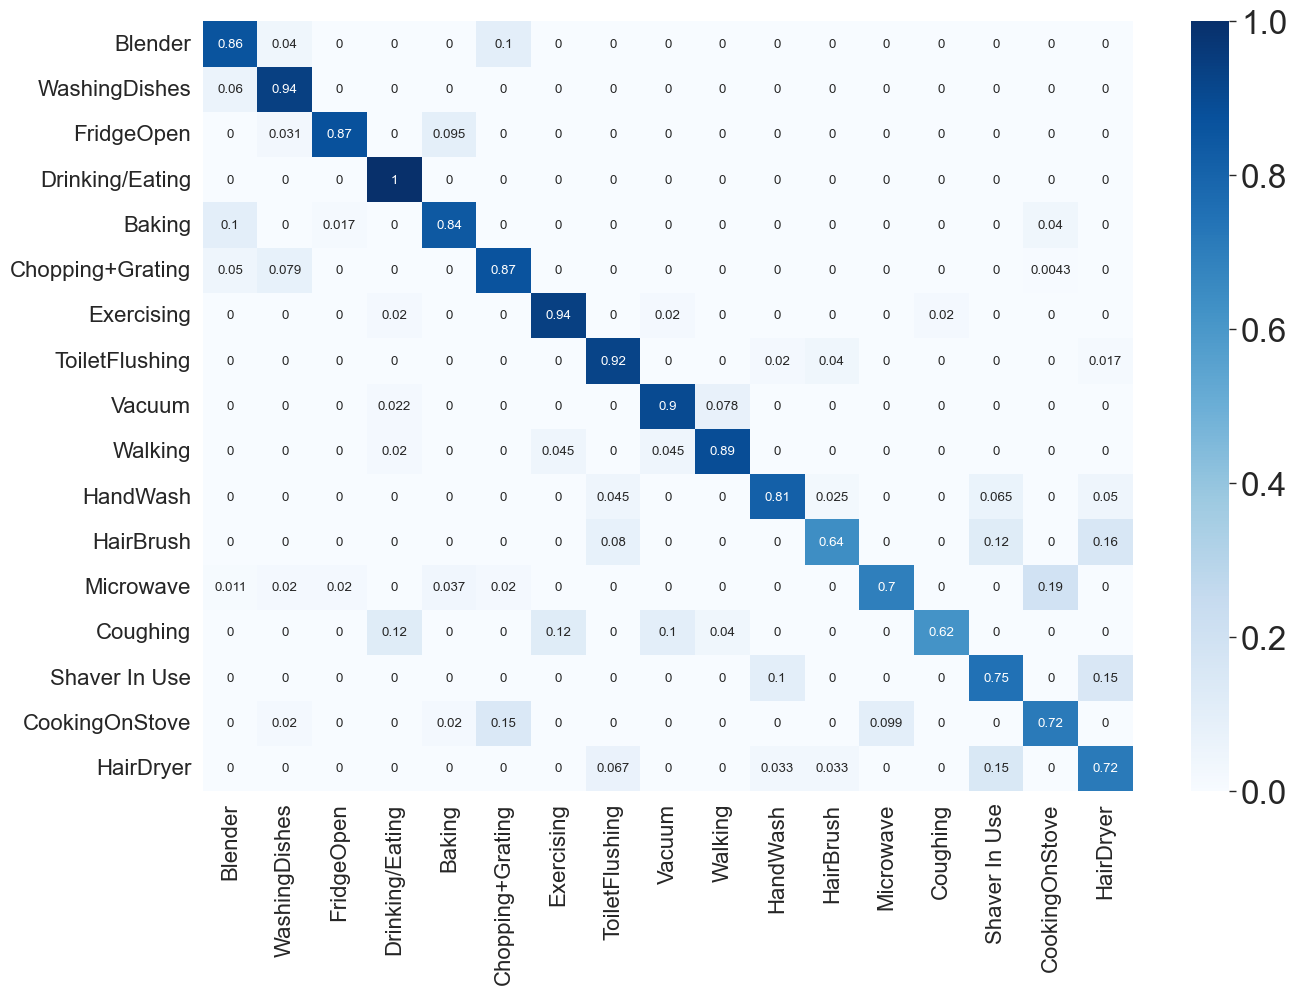

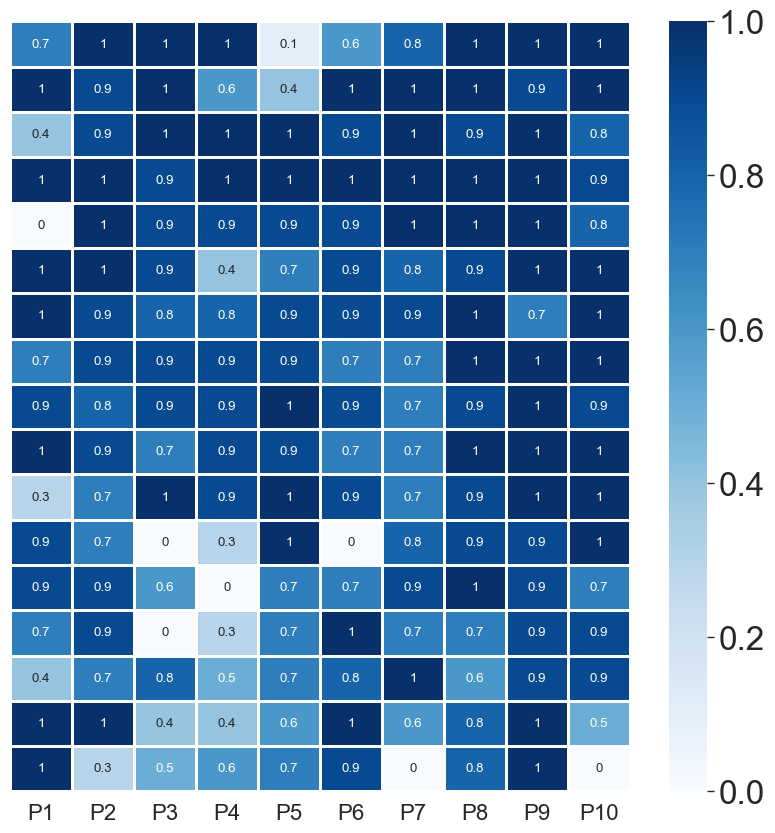

In [28]:
df_pvs_results = pd.read_csv('/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_all.csv',index_col=0)
# df_pvs_results = df_pvs_results[df_pvs_results.label_in_av]
df_pvs_results.columns=['user','instance_id','gt','av','prediction','score','sensor']
df_pvs_results.loc[df_pvs_results['gt'].isin(['ToilerFlushing']), 'gt'] = 'ToiletFlushing'
df_pvs_results.loc[df_pvs_results['prediction'].isin(['ToilerFlushing']), 'prediction'] = 'ToiletFlushing'

df_pvs_results.info()
df_pvs_results.head()
df_pvs_results['pred_score'] = df_pvs_results.apply(lambda row: f'{row["prediction"]}_{round(row["score"], 3)}', axis=1)
# get timestamp level metrics for all sensors which includes APR,

df_pvs_results_all = df_pvs_results[df_pvs_results.sensor == 'best']
df_pvs_results_all = df_pvs_results_all.groupby(['user', 'instance_id', 'gt'], as_index=False).agg(
    {'pred_score': lambda x: best_prediction_combo(x)})
df_pvs_results_all['prediction'] = df_pvs_results_all['pred_score']
# df_pvs_results_all.loc[df_pvs_results_all['gt'].isin(['Chopping', 'Grating']), 'gt'] = 'Chopping+Grating'
# df_pvs_results_all.loc[
#     df_pvs_results_all['prediction'].isin(['Chopping', 'Grating']), 'prediction'] = 'Chopping+Grating'

user_cf = []
user_pvs_precision_all = []
user_pvs_recall_all = []
user_pvs_f1_all = []
user_pvs_apr = []
for user in users:
    df_pvs_result_users = df_pvs_results_all[df_pvs_results_all.user == user]
    # df_pvs_result_users = df_pvs_result_users[~(df_pvs_result_users.prediction=='NotDetected')]

    #user confusion matrix
    conf_mat_pvs = confusion_matrix(df_pvs_result_users['gt'], df_pvs_result_users['prediction'], labels=activities)
    conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
    user_cf.append(conf_mat_pvs)

    #user level precision
    user_pvs_precision_all.append(
        precision_score(df_pvs_result_users['gt'], df_pvs_result_users['prediction'], average=None, labels=activities,
                        zero_division=0))
    user_pvs_recall_all.append(
        recall_score(df_pvs_result_users['gt'], df_pvs_result_users['prediction'], average=None, labels=activities,
                     zero_division=0))
    user_pvs_f1_all.append(
        f1_score(df_pvs_result_users['gt'], df_pvs_result_users['prediction'], average=None, labels=activities,
                     zero_division=1))

    user_pvs_apr.append([
        accuracy_score(df_pvs_result_users['gt'], df_pvs_result_users['prediction'], ),
        precision_score(df_pvs_result_users['gt'], df_pvs_result_users['prediction'], average='weighted',
                        labels=activities, zero_division=0),
        recall_score(df_pvs_result_users['gt'], df_pvs_result_users['prediction'], average='weighted',
                     labels=activities, zero_division=0),
    ])
df_pvs_precision = pd.DataFrame(np.array(user_pvs_precision_all).T, columns=users, index=activities)
df_pvs_recall = pd.DataFrame(np.array(user_pvs_recall_all).T, columns=users, index=activities)
df_pvs_f1 = pd.DataFrame(np.array(user_pvs_f1_all).T, columns=users, index=activities)
df_pvs_apr = pd.DataFrame(user_pvs_apr, columns=['Accuracy', 'Precision', 'Recall'], index=users).round(2) * 100
df_conf_mat_pvs = pd.DataFrame(np.nanmean(user_cf, axis=0)[1:, 1:], index=activities[1:], columns=activities[1:])
# Plot confusion matrix
_ = plt.figure(figsize=(15, 10))
sns.heatmap(df_conf_mat_pvs.loc[idx_sorted_best_x,idx_sorted_best_x], annot=True,cmap='Blues')
plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)
plt.savefig(f'{plotting_dir}/E2_pvs_activity_confusion.png', dpi=150, bbox_inches='tight')

# User Precision matrix
# _ = plt.figure(figsize=(15, 10))
# sns.heatmap(df_pvs_precision.iloc[1:, :], annot=True, linecolor='w', linewidths=1,cmap='Blues')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.savefig(f'{plotting_dir}/E2_pvs_participant_activity_precision.png', dpi=150, bbox_inches='tight')
#
# _ = plt.figure(figsize=(15, 10))
# sns.heatmap(df_pvs_recall.iloc[1:, :], annot=True, linecolor='w', linewidths=1,cmap='Blues')
# plt.xticks(fontsize=16)
# _ = plt.yticks(fontsize=16)
# plt.savefig(f'{plotting_dir}/E2_pvs_participant_activity_recall.png', dpi=150, bbox_inches='tight')
#

_ = plt.figure(figsize=(10, 10))
idx_sorted = df_pvs_f1.iloc[1:, :].median(axis=1).sort_values(ascending=False).index
ax = sns.heatmap(df_pvs_f1.iloc[1:, :].loc[idx_sorted_best_x].round(1), annot=True, linecolor='w', linewidths=1,cmap='Blues')
plt.yticks([])
plt.xticks(fontsize=16)
# _ = plt.yticks(fontsize=16)
plt.savefig(f'{plotting_dir}/E2_pvs_participant_activity_f1.png', dpi=150, bbox_inches='tight')


In [29]:
idx_sorted_best_x =deepcopy(idx_sorted)
idx_sorted_best_x

Index(['Blender', 'WashingDishes', 'FridgeOpen', 'Drinking/Eating', 'Baking',
       'Chopping+Grating', 'Exercising', 'ToiletFlushing', 'Vacuum', 'Walking',
       'HandWash', 'HairBrush', 'Microwave', 'Coughing', 'Shaver In Use',
       'CookingOnStove', 'HairDryer'],
      dtype='object')

85.0 85.5 85.0


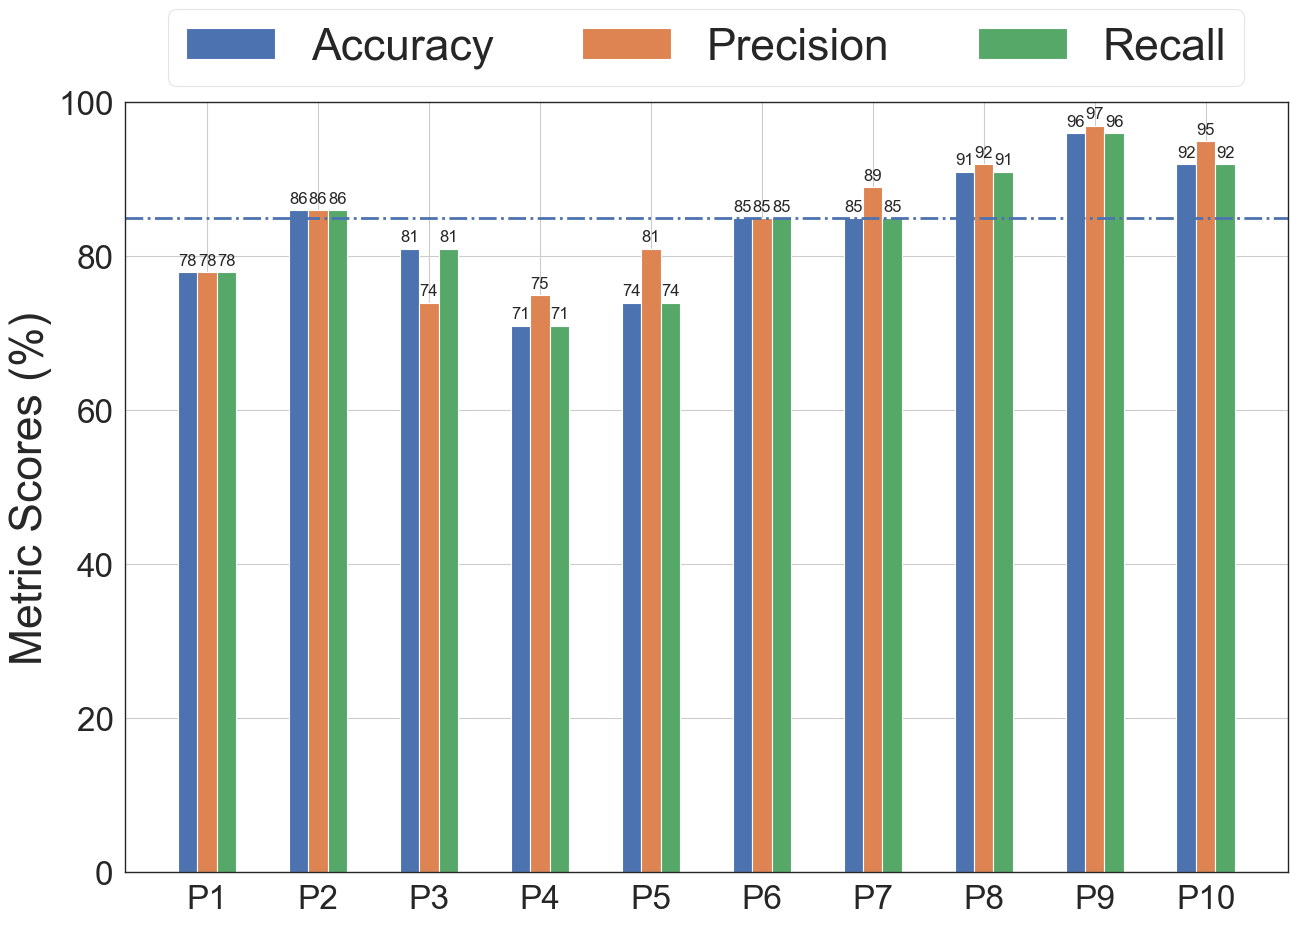

In [30]:
# Final APR matrix for PVS at participant level
labels = users
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
rects1 = ax.bar(x - width / 2, df_pvs_apr['Accuracy'], width / 2, label='Accuracy')
rects2 = ax.bar(x, df_pvs_apr['Precision'], width / 2, label='Precision')
rects3 = ax.bar(x + width / 2, df_pvs_apr['Recall'], width / 2, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Scores (%)')
# ax.set_title(f'A/P/R Metrics: {k_value} results')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=12)
ax.bar_label(rects2, padding=3, fontsize=12)
ax.bar_label(rects3, padding=3, fontsize=12)

acc, prec, recall = df_pvs_apr.median(axis=0).values
print(acc, prec, recall)
ax.axhline(acc, linestyle='-.', linewidth=2)
# ax.axhline(prec, linestyle='-', linewidth=1)
# ax.axhline(recall, linestyle='--', linewidth=1)
plt.legend(loc='upper center', ncol=3,bbox_to_anchor = [0.5, 1.15])
# fig.tight_layout()
plt.ylim(top=100)
plt.savefig(f'{plotting_dir}/E2_apr_participants.png', dpi=150, bbox_inches='tight')


In [31]:
df_pvs_results.sensor.value_counts()

best        1025
doppler     1019
ENV          996
PIR          996
thermal      994
lidar        973
micarray     731
Name: sensor, dtype: int64

In [32]:
# Sensor level matrix
df_pvs_results_sensors = df_pvs_results[~(df_pvs_results.sensor == 'best')]

sensor_name = []
sensor_cf = []
sensor_pvs_precision = []
sensor_pvs_f1 = []
sensor_pvs_apr = []
for sensor in df_pvs_results_sensors.sensor.unique():
    if not sensor == 'best':
        df_pvs_result_sensor = df_pvs_results[df_pvs_results.sensor == sensor]
        print(sensor, df_pvs_result_sensor.shape)
        sensor_user_cf = []
        sensor_user_pvs_precision = []
        sensor_user_pvs_f1 = []
        sensor_user_pvs_apr = []
        for sensor_user in users:
            df_pvs_result_sensor_user = df_pvs_result_sensor[df_pvs_result_sensor.user == sensor_user]
            if df_pvs_result_sensor_user.shape[0] > 0.:

                #sensor_user confusion matrix
                conf_mat_pvs_sensor = confusion_matrix(df_pvs_result_sensor_user['gt'],
                                                       df_pvs_result_sensor_user['prediction'], labels=activities)
                conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
                sensor_user_cf.append(conf_mat_pvs_sensor)

                #sensor_user level precision
                sensor_user_pvs_precision.append(
                    precision_score(df_pvs_result_sensor_user['gt'], df_pvs_result_sensor_user['prediction'],
                                    average=None, labels=activities, zero_division=0))
                sensor_user_pvs_f1.append(
                    f1_score(df_pvs_result_sensor_user['gt'], df_pvs_result_sensor_user['prediction'], average=None,
                                 labels=activities, zero_division=0))
                sensor_user_pvs_apr.append([
                    accuracy_score(df_pvs_result_sensor_user['gt'], df_pvs_result_sensor_user['prediction'], ),
                    precision_score(df_pvs_result_sensor_user['gt'], df_pvs_result_sensor_user['prediction'],
                                    average='weighted', labels=activities, zero_division=0),
                    f1_score(df_pvs_result_sensor_user['gt'], df_pvs_result_sensor_user['prediction'],
                                 average='weighted', labels=activities, zero_division=0),
                ])
            else:
                sensor_user_cf.append(np.full((len(activities), len(activities)), fill_value=np.nan))
                sensor_user_pvs_precision.append(np.full(len(activities), fill_value=np.nan))
                sensor_user_pvs_f1.append(np.full(len(activities), fill_value=np.nan))
                sensor_user_pvs_apr.append(np.full(3, fill_value=np.nan))

        df_pvs_sensor_precision = pd.DataFrame(np.array(sensor_user_pvs_precision).T, columns=users, index=activities)
        df_pvs_sensor_f1 = pd.DataFrame(np.array(sensor_user_pvs_f1).T, columns=users, index=activities)
        df_pvs_sensor_apr = pd.DataFrame(sensor_user_pvs_apr, columns=['Accuracy', 'Precision', 'Recall'],
                                         index=users).round(2) * 100
        df_conf_mat_pvs_sensor = pd.DataFrame(np.nanmean(sensor_user_cf, axis=0)[1:, 1:], index=activities[1:],
                                              columns=activities[1:])

        sensor_name.append(sensor)
        sensor_pvs_precision.append(np.nanmean(df_pvs_sensor_precision.values, axis=1))
        sensor_pvs_f1.append(np.nanmean(df_pvs_sensor_f1.values, axis=1))
        sensor_pvs_apr.append(np.nanmean(df_pvs_sensor_apr.values, axis=0))


thermal (994, 8)
doppler (1019, 8)
lidar (973, 8)
micarray (731, 8)


/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWar

ENV (996, 8)
PIR (996, 8)


/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:51: RuntimeWarning: Mean of empty slice
  df_conf_mat_pvs_sensor = pd.DataFrame(np.nanmean(sensor_user_cf, axis=0)[1:, 1:], index=activities[1:],
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/574421834.py:24: RuntimeWarnin

In [33]:
df_pvs_results_sensors = df_pvs_results[~(df_pvs_results.sensor == 'best')]

df_pvs_results_sensors

,user,instance_id,gt,av,prediction,score,sensor,pred_score
0,P1,P1_000,Vacuum,Vacuum,Vacuum,0.493964,thermal,Vacuum_0.494
1,P1,P1_001,Vacuum,Vacuum,Vacuum,0.953163,thermal,Vacuum_0.953
2,P1,P1_002,Coughing,Coughing,Drinking/Eating,0.500000,thermal,Drinking/Eating_0.5
3,P1,P1_003,Drinking/Eating,Drinking/Eating,Coughing,1.000000,thermal,Coughing_1.0
4,P1,P1_007,Walking,Walking,Walking,0.693939,thermal,Walking_0.694
...,...,...,...,...,...,...,...,...
991,P9,P9_142,WashingDishes,Undetected,CookingOnStove,0.646644,PIR,CookingOnStove_0.647
992,P9,P9_143,WashingDishes,WashingDishes,WashingDishes,0.642857,PIR,WashingDishes_0.643
993,P9,P9_144,WashingDishes,WashingDishes,Microwave,0.500000,PIR,Microwave_0.5
994,P9,P9_145,WashingDishes,WashingDishes,Blender,0.500000,PIR,Blender_0.5


In [34]:
sensor_pvs_precision

[array([0.        , 0.83809524, 0.83333333, 0.89577922, 0.8144697 ,
        0.72      , 0.82389277, 0.7847619 , 0.79333333, 0.7097619 ,
        0.395     , 0.83095238, 0.75727273, 0.71345238, 0.91809524,
        0.65      , 0.6772619 , 0.77285714]),
 array([0.        , 0.83      , 0.60429293, 0.85883202, 0.78      ,
        0.80166667, 0.86329004, 0.81031746, 0.83214286, 0.58285714,
        0.34305195, 0.8525    , 0.73769841, 0.66194444, 0.835     ,
        0.72905983, 0.8       , 0.84607041]),
 array([0.        , 0.6547619 , 0.67212121, 0.73733766, 0.58333333,
        0.805     , 0.86764069, 0.77452381, 0.65854978, 0.4552381 ,
        0.14393162, 0.72416667, 0.62799423, 0.43404762, 0.78547619,
        0.62944444, 0.755     , 0.75265152]),
 array([0.        , 0.32993197, 0.48755411, 0.42077922, 0.49848485,
        0.66666667, 0.76431188, 0.40634921, 0.4872449 , 0.51870748,
        0.26122449, 0.47108844, 0.47963941, 0.38367347, 0.44588745,
        0.67210884, 0.45306122, 0.57996468]),


In [35]:
df_sensor_precision = pd.DataFrame(np.array(sensor_pvs_precision).T[1:, :], index=activities[1:], columns=sensor_name)
df_sensor_f1 = pd.DataFrame(np.array(sensor_pvs_f1).T[1:, :], index=activities[1:], columns=sensor_name)

In [36]:
df_sensor_f1.columns

Index(['thermal', 'doppler', 'lidar', 'micarray', 'ENV', 'PIR'], dtype='object')

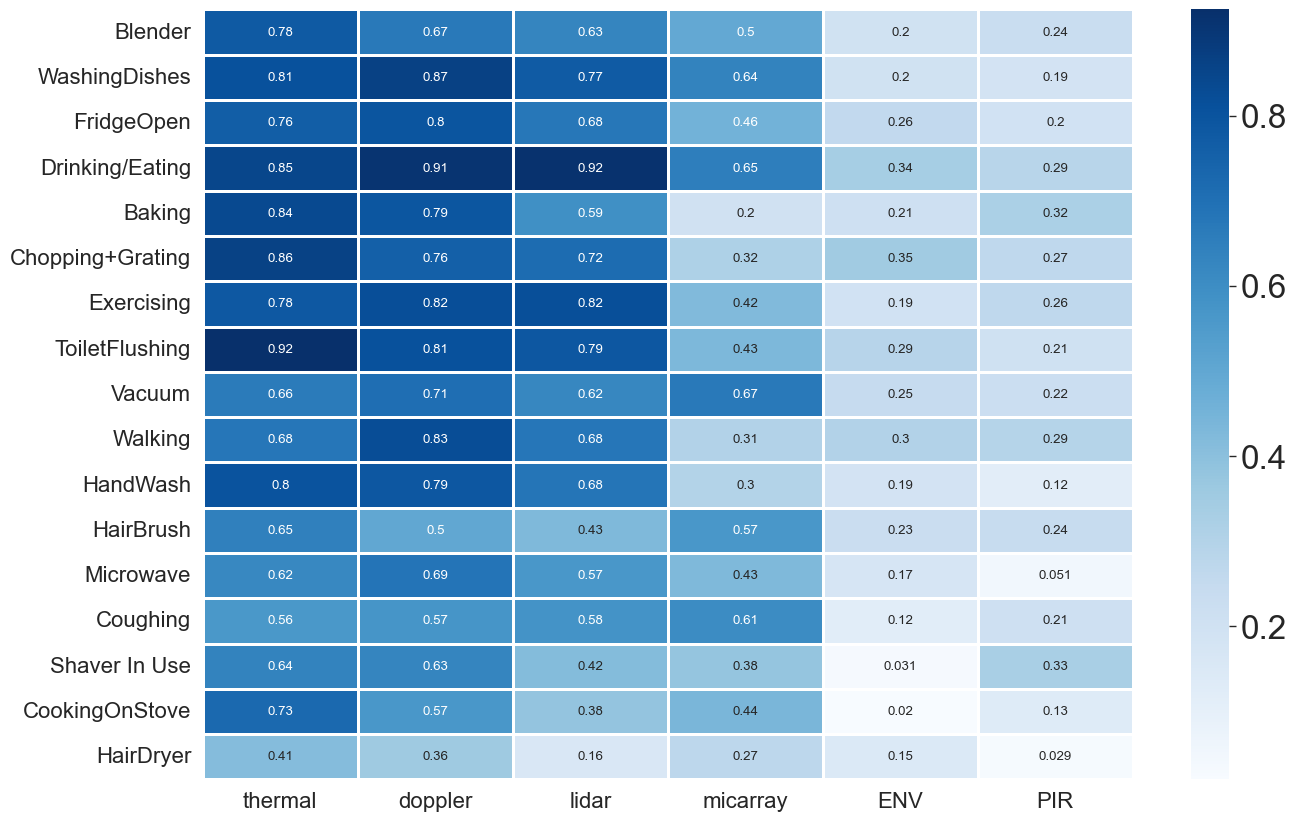

In [37]:
# _ = plt.figure(figsize=(15, 10))
# sns.heatmap(df_sensor_precision, annot=True, linecolor='w', linewidths=1, cmap='Blues')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.savefig(f'{plotting_dir}/E2_pvs_sensor_activity_precision.png', dpi=150, bbox_inches='tight')

_ = plt.figure(figsize=(15, 10))
sns.heatmap(df_sensor_f1.loc[idx_sorted_best_x], annot=True, linecolor='w', linewidths=1, cmap='Blues')
plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)
plt.savefig(f'{plotting_dir}/E2_pvs_sensor_activity_f1.png', dpi=150, bbox_inches='tight')


# Eval: PVS results for noinput samples


In [40]:
df_pvs_nosample_results = pd.read_csv('/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_noinput_all.csv',index_col=0)
# df_pvs_nosample_results = df_pvs_nosample_results[df_pvs_nosample_results.label_in_av]
df_pvs_nosample_results.columns=['user','instance_id','gt','av','prediction','score','sensor']
df_pvs_nosample_results.loc[df_pvs_nosample_results['gt'].isin(['ToilerFlushing']), 'gt'] = 'ToiletFlushing'
df_pvs_nosample_results.loc[df_pvs_nosample_results['prediction'].isin(['ToilerFlushing']), 'prediction'] = 'ToiletFlushing'

df_pvs_nosample_results.info()
df_pvs_nosample_results.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 1043
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user         1044 non-null   object 
 1   instance_id  1044 non-null   object 
 2   gt           1044 non-null   object 
 3   av           1044 non-null   object 
 4   prediction   1044 non-null   object 
 5   score        1044 non-null   float64
 6   sensor       1044 non-null   object 
dtypes: float64(1), object(6)
memory usage: 65.2+ KB


,user,instance_id,gt,av,prediction,score,sensor
0,P1,P1_000,Vacuum,Vacuum,Vacuum,0.510399,best
1,P1,P1_001,Vacuum,Vacuum,Vacuum,0.774918,best
2,P1,P1_002,Coughing,Coughing,Coughing,0.513461,best
3,P1,P1_003,Drinking/Eating,Drinking/Eating,Coughing,0.488180,best
4,P1,P1_007,Walking,Walking,Walking,0.606522,best


In [41]:
idx_sorted

Index(['Blender', 'WashingDishes', 'FridgeOpen', 'Drinking/Eating', 'Baking',
       'Chopping+Grating', 'Exercising', 'ToiletFlushing', 'Vacuum', 'Walking',
       'HandWash', 'HairBrush', 'Microwave', 'Coughing', 'Shaver In Use',
       'CookingOnStove', 'HairDryer'],
      dtype='object')

/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/502451847.py:23: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/502451847.py:23: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/502451847.py:23: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/502451847.py:23: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/502451847.py:23: RuntimeWarning: invalid value encountered in divide
  conf_mat_pvs = conf_mat_pvs / conf_mat_p

73.5 69.0 73.5


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

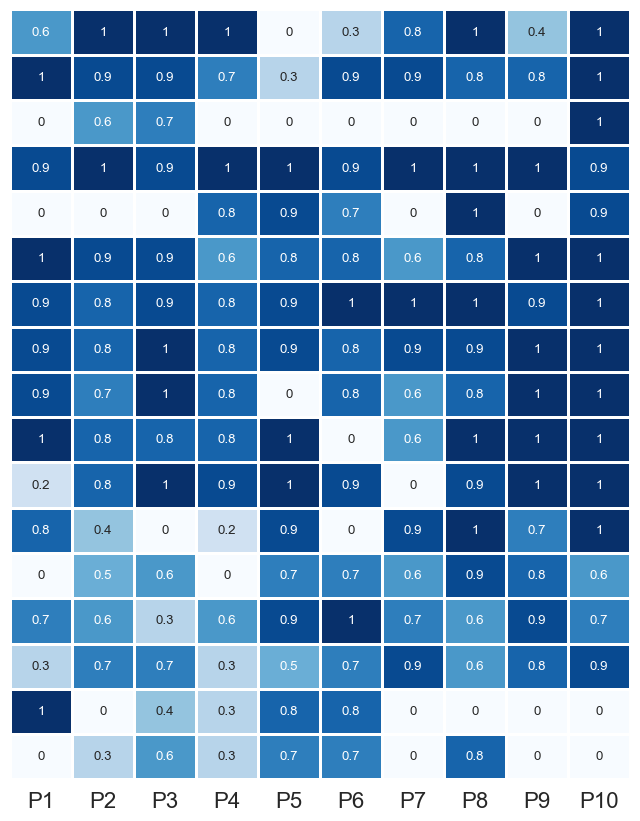

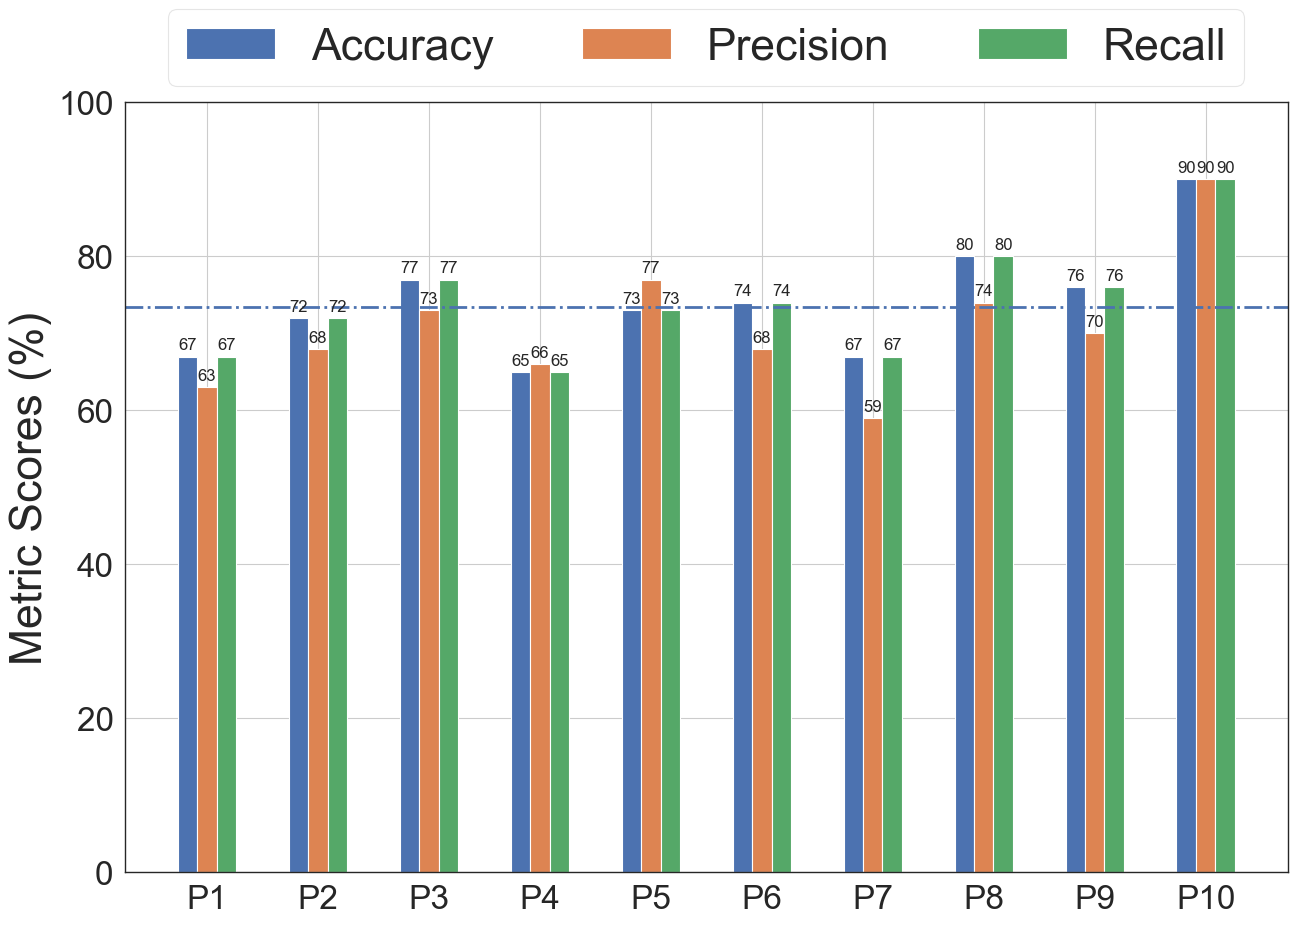

In [42]:
df_pvs_nosample_results['pred_score'] = df_pvs_nosample_results.apply(lambda row: f'{row["prediction"]}_{round(row["score"], 3)}', axis=1)
# get timestamp level metrics for all sensors which includes APR,

df_pvs_nosample_results_all = df_pvs_nosample_results[df_pvs_nosample_results.sensor == 'best']
df_pvs_nosample_results_all = df_pvs_nosample_results_all.groupby(['user', 'instance_id', 'gt'], as_index=False).agg(
    {'pred_score': lambda x: best_prediction_combo(x)})
df_pvs_nosample_results_all['prediction'] = df_pvs_nosample_results_all['pred_score']
# df_pvs_nosample_results_all.loc[df_pvs_nosample_results_all['gt'].isin(['Chopping', 'Grating']), 'gt'] = 'Chopping+Grating'
# df_pvs_nosample_results_all.loc[
#     df_pvs_nosample_results_all['prediction'].isin(['Chopping', 'Grating']), 'prediction'] = 'Chopping+Grating'

user_cf = []
user_pvs_precision_all = []
user_pvs_recall_all = []
user_pvs_f1_all = []
user_pvs_apr = []
for user in users:
    df_pvs_nosample_result_users = df_pvs_nosample_results_all[df_pvs_nosample_results_all.user == user]
    # df_pvs_nosample_result_users = df_pvs_nosample_result_users[~(df_pvs_nosample_result_users.prediction=='NotDetected')]

    #user confusion matrix
    conf_mat_pvs = confusion_matrix(df_pvs_nosample_result_users['gt'], df_pvs_nosample_result_users['prediction'], labels=activities)
    conf_mat_pvs = conf_mat_pvs / conf_mat_pvs.sum(axis=1)[:, np.newaxis]
    user_cf.append(conf_mat_pvs)

    #user level precision
    user_pvs_precision_all.append(
        precision_score(df_pvs_nosample_result_users['gt'], df_pvs_nosample_result_users['prediction'], average=None, labels=activities,
                        zero_division=0))
    user_pvs_recall_all.append(
        recall_score(df_pvs_nosample_result_users['gt'], df_pvs_nosample_result_users['prediction'], average=None, labels=activities,
                     zero_division=0))
    user_pvs_f1_all.append(
        f1_score(df_pvs_nosample_result_users['gt'], df_pvs_nosample_result_users['prediction'], average=None, labels=activities,
                 zero_division=0))

    user_pvs_apr.append([
        accuracy_score(df_pvs_nosample_result_users['gt'], df_pvs_nosample_result_users['prediction'], ),
        precision_score(df_pvs_nosample_result_users['gt'], df_pvs_nosample_result_users['prediction'], average='weighted',
                        labels=activities, zero_division=0),
        recall_score(df_pvs_nosample_result_users['gt'], df_pvs_nosample_result_users['prediction'], average='weighted',
                     labels=activities, zero_division=0),
    ])
df_pvs_precision = pd.DataFrame(np.array(user_pvs_precision_all).T, columns=users, index=activities)
df_pvs_recall = pd.DataFrame(np.array(user_pvs_recall_all).T, columns=users, index=activities)
df_pvs_f1 = pd.DataFrame(np.array(user_pvs_f1_all).T, columns=users, index=activities)
df_pvs_apr = pd.DataFrame(user_pvs_apr, columns=['Accuracy', 'Precision', 'Recall'], index=users).round(2) * 100
df_conf_mat_pvs = pd.DataFrame(np.nanmean(user_cf, axis=0)[1:, 1:], index=activities[1:], columns=activities[1:])
# Plot confusion matrix
# _ = plt.figure(figsize=(15, 10))
# sns.heatmap(df_conf_mat_pvs, annot=True, cmap='Blues')
# plt.xticks(fontsize=16)
# _ = plt.yticks(fontsize=16)
# plt.savefig(f'{plotting_dir}/E2_nosample_pvs_activity_confusion.png', dpi=150, bbox_inches='tight')

# User Precision matrix
# _ = plt.figure(figsize=(15, 10))
# sns.heatmap(df_pvs_precision.iloc[1:, :], annot=True, linecolor='w', linewidths=1,cmap='Blues')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.savefig(f'{plotting_dir}/E2_nosample_pvs_participant_activity_precision.png', dpi=150, bbox_inches='tight')
#
# _ = plt.figure(figsize=(15, 10))
# sns.heatmap(df_pvs_recall.iloc[1:, :], annot=True, linecolor='w', linewidths=1,cmap='Blues')
# plt.xticks(fontsize=16)
# _ = plt.yticks(fontsize=16)
# plt.savefig(f'{plotting_dir}/E2_nosample_pvs_participant_activity_recall.png', dpi=150, bbox_inches='tight')
#

_ = plt.figure(figsize=(8, 10))
# idx_sorted = df_pvs_f1.iloc[1:, :].median(axis=1).sort_values(ascending=False).index
sns.heatmap(df_pvs_f1.iloc[1:, :].loc[idx_sorted_best_x].round(1), annot=True, linecolor='w', linewidths=1, cmap='Blues',cbar=False)
plt.xticks(fontsize=16)
plt.yticks([])
plt.savefig(f'{plotting_dir}/E2_nosample_pvs_participant_activity_f1.png', dpi=150, bbox_inches='tight')

# Final APR matrix for PVS at participant level
labels = users
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
rects1 = ax.bar(x - width / 2, df_pvs_apr['Accuracy'], width / 2, label='Accuracy')
rects2 = ax.bar(x, df_pvs_apr['Precision'], width / 2, label='Precision')
rects3 = ax.bar(x + width / 2, df_pvs_apr['Recall'], width / 2, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Scores (%)')
# ax.set_title(f'A/P/R Metrics: {k_value} results')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=12)
ax.bar_label(rects2, padding=3, fontsize=12)
ax.bar_label(rects3, padding=3, fontsize=12)

acc, prec, recall = df_pvs_apr.median(axis=0).values
print(acc,prec,recall)
ax.axhline(acc, linestyle='-.', linewidth=2)
# ax.axhline(prec, linestyle='-', linewidth=1)
# ax.axhline(recall, linestyle='--', linewidth=1)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.15])
# fig.tight_layout()
plt.ylim(top=100)
plt.savefig(f'{plotting_dir}/E2_nosample_apr_participants.png', dpi=150, bbox_inches='tight')

df_pvs_nosample_results.sensor.unique()
# Sensor level matrix
df_pvs_nosample_results_sensors = df_pvs_nosample_results[~(df_pvs_nosample_results.sensor == 'best')]

sensor_name = []
sensor_cf = []
sensor_pvs_precision = []
sensor_pvs_f1 = []
sensor_pvs_apr = []
for sensor in df_pvs_nosample_results_sensors.sensor.unique():
    if not sensor == 'best':
        df_pvs_nosample_result_sensor = df_pvs_nosample_results[df_pvs_nosample_results.sensor == sensor]
        print(sensor, df_pvs_nosample_result_sensor.shape)
        sensor_user_cf = []
        sensor_user_pvs_precision = []
        sensor_user_pvs_f1 = []
        sensor_user_pvs_apr = []
        for sensor_user in users:
            df_pvs_nosample_result_sensor_user = df_pvs_nosample_result_sensor[df_pvs_nosample_result_sensor.user == sensor_user]
            if df_pvs_nosample_result_sensor_user.shape[0] > 0.:

                #sensor_user confusion matrix
                conf_mat_pvs_sensor = confusion_matrix(df_pvs_nosample_result_sensor_user['gt'],
                                                       df_pvs_nosample_result_sensor_user['prediction'], labels=activities)
                conf_mat_pvs_sensor = conf_mat_pvs_sensor / conf_mat_pvs_sensor.sum(axis=1)[:, np.newaxis]
                sensor_user_cf.append(conf_mat_pvs_sensor)

                #sensor_user level precision
                sensor_user_pvs_precision.append(
                    precision_score(df_pvs_nosample_result_sensor_user['gt'], df_pvs_nosample_result_sensor_user['prediction'],
                                    average=None, labels=activities, zero_division=0))
                sensor_user_pvs_f1.append(
                    f1_score(df_pvs_nosample_result_sensor_user['gt'], df_pvs_nosample_result_sensor_user['prediction'], average=None,
                             labels=activities, zero_division=0))
                sensor_user_pvs_apr.append([
                    accuracy_score(df_pvs_nosample_result_sensor_user['gt'], df_pvs_nosample_result_sensor_user['prediction'], ),
                    precision_score(df_pvs_nosample_result_sensor_user['gt'], df_pvs_nosample_result_sensor_user['prediction'],
                                    average='weighted', labels=activities, zero_division=0),
                    f1_score(df_pvs_nosample_result_sensor_user['gt'], df_pvs_nosample_result_sensor_user['prediction'],
                             average='weighted', labels=activities, zero_division=0),
                ])
            else:
                sensor_user_cf.append(np.full((len(activities), len(activities)), fill_value=np.nan))
                sensor_user_pvs_precision.append(np.full(len(activities), fill_value=np.nan))
                sensor_user_pvs_f1.append(np.full(len(activities), fill_value=np.nan))
                sensor_user_pvs_apr.append(np.full(3, fill_value=np.nan))

        df_pvs_sensor_precision = pd.DataFrame(np.array(sensor_user_pvs_precision).T, columns=users, index=activities)
        df_pvs_sensor_f1 = pd.DataFrame(np.array(sensor_user_pvs_f1).T, columns=users, index=activities)
        df_pvs_sensor_apr = pd.DataFrame(sensor_user_pvs_apr, columns=['Accuracy', 'Precision', 'Recall'],
                                         index=users).round(2) * 100
        df_conf_mat_pvs_sensor = pd.DataFrame(np.nanmean(sensor_user_cf, axis=0)[1:, 1:], index=activities[1:],
                                              columns=activities[1:])

        sensor_name.append(sensor)
        sensor_pvs_precision.append(np.nanmean(df_pvs_sensor_precision.values, axis=1))
        sensor_pvs_f1.append(np.nanmean(df_pvs_sensor_f1.values, axis=1))
        sensor_pvs_apr.append(np.nanmean(df_pvs_sensor_apr.values, axis=0))

df_pvs_nosample_results_sensors = df_pvs_nosample_results[~(df_pvs_nosample_results.sensor == 'best')]

df_pvs_nosample_results_sensors
sensor_pvs_precision
df_sensor_precision = pd.DataFrame(np.array(sensor_pvs_precision).T[1:, :], index=activities[1:], columns=sensor_name)
df_sensor_f1 = pd.DataFrame(np.array(sensor_pvs_f1).T[1:, :], index=activities[1:], columns=sensor_name)
df_sensor_f1.columns
_ = plt.figure(figsize=(15, 10))
sns.heatmap(df_sensor_precision, annot=True, linecolor='w', linewidths=1, cmap='Blues')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(f'{plotting_dir}/E2_nosample_pvs_sensor_activity_precision.png', dpi=150, bbox_inches='tight')

_ = plt.figure(figsize=(15, 10))
sns.heatmap(df_sensor_f1, annot=True, linecolor='w', linewidths=1, cmap='Blues')
plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)
plt.savefig(f'{plotting_dir}/E2_nosample_pvs_sensor_activity_f1.png', dpi=150, bbox_inches='tight')

# Modified graphs for support

In [39]:
# get top sensor combinations at each sensor budget and show boxplot of accuracy across users
df_doppler_support = pd.read_csv("/Users/ppatida2/VAX/vax/HAR/evaluation/external/doppler_support_clusters.csv",index_col=0)
df_doppler_support.columns = ['instance_id','Activity','tsne_x','tsne_y','Cluster']
df_doppler_support.head()

,instance_id,Activity,tsne_x,tsne_y,Cluster
1666991825155705988,P10_000,Vacuum,44.612510,4.022100,-1
1666991825321880826,P10_000,Vacuum,44.284004,4.049582,-1
1666991825488243348,P10_000,Vacuum,43.649086,3.665010,-1
1666991825621484237,P10_000,Vacuum,43.487370,4.220110,-1
1666991825856012506,P10_000,Vacuum,43.313087,4.527198,-1


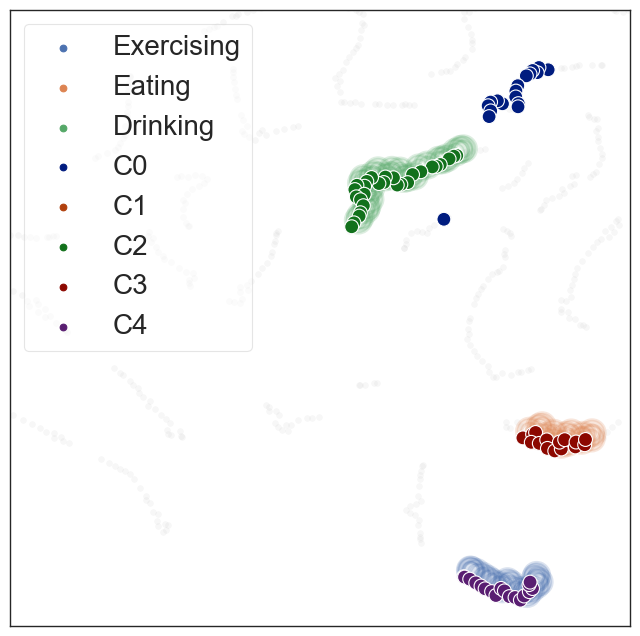

In [205]:
import matplotlib.lines
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=df_doppler_support[df_doppler_support.Cluster<0], x='tsne_x',y='tsne_y',color='k',alpha=0.03)
sns.scatterplot(data=df_doppler_support[(df_doppler_support.Cluster>0)], x='tsne_x',y='tsne_y',hue='Activity',marker='$\circ$',ec='face',s=800,alpha=0.2)
ax.plot([],[],linestyle='',label='')
sns.scatterplot(data=df_doppler_support[df_doppler_support.Cluster>=0], x='tsne_x',y='tsne_y',hue='Cluster',ax=ax, palette='dark',s=100)
ax.legend(fontsize=20)
#get legend and change stuff
handles, labels_legend = ax.get_legend_handles_labels()
for idx,h in enumerate(handles):
    if labels_legend[idx] not in activities+['Eating','Drinking']:
        labels_legend[idx] = f'C{labels_legend[idx]}'
ax.legend(handles, labels_legend, fontsize=20)

# ax.legend.set_title("Clusters")
ax.set_ylabel('')
ax.set_xlabel('')

ax.set_xlim(-25,25)
ax.set_ylim(-40,20)
ax.set_xticks([])
ax.set_yticks([])
# plt.axis('off')

plt.savefig(f'{plotting_dir}/doppler_support.png',bbox_inches='tight',dpi=300)

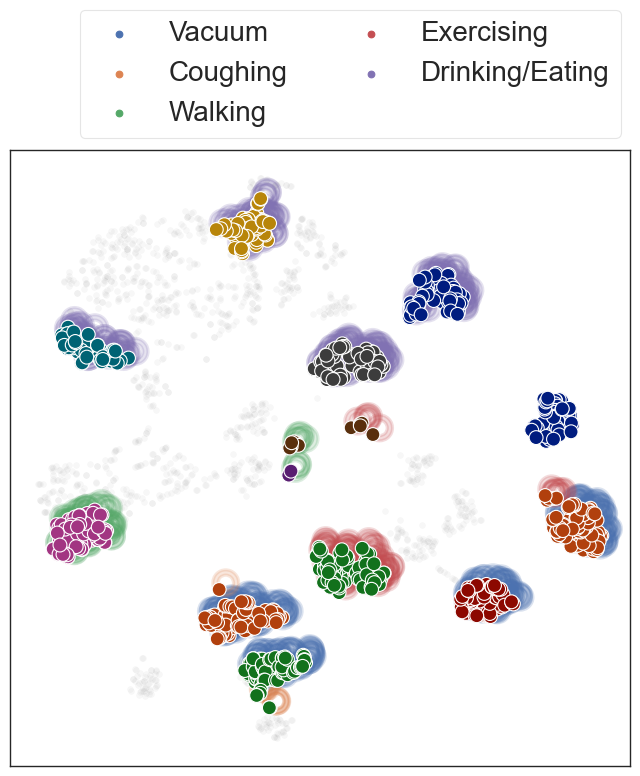

In [27]:
# get top sensor combinations at each sensor budget and show boxplot of accuracy across users
df_lidar_support = pd.read_csv("/Users/ppatida2/VAX/vax/HAR/evaluation/external/lidar_support_clusters.csv",
                                 index_col=0)
df_lidar_support.columns = ['instance_id', 'Activity', 'tsne_x', 'tsne_y', 'Cluster']
df_lidar_support.loc[df_lidar_support.Activity.isin(['Drinking','Eating']),'Activity'] = 'Drinking/Eating'
df_lidar_support.head()
import matplotlib.lines

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
df_lidar_support = df_lidar_support[~df_lidar_support.Activity.isin(['Knocking'])]
sns.scatterplot(data=df_lidar_support[df_lidar_support.Cluster < 0], x='tsne_x', y='tsne_y', color='k', alpha=0.03)
sns.scatterplot(data=df_lidar_support[(df_lidar_support.Cluster > 0)], x='tsne_x', y='tsne_y', hue='Activity',
                marker='$\circ$', ec='face', s=800, alpha=0.2)
ax.plot([], [], linestyle='', label='')
sns.scatterplot(data=df_lidar_support[df_lidar_support.Cluster >= 0], x='tsne_x', y='tsne_y', hue='Cluster', ax=ax,
                palette='dark', s=100)
ax.legend(fontsize=20)
#get legend and change stuff
handles, labels_legend = ax.get_legend_handles_labels()
for idx, h in enumerate(handles):
    # h.set_markersize(40)
    if labels_legend[idx] not in activities + ['Eating', 'Drinking']:
        break
        # labels_legend[idx] = f'C{labels_legend[idx]}'
lg = ax.legend(handles[:idx], labels_legend[:idx], fontsize=20, ncol=2,bbox_to_anchor=(0.09,1.25))
# for handle in lg.legendHandles:
#     handle._legmarker.set_markersize(20)
# ax.legend.set_title("Clusters")
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_xlim(-25, 25)
# ax.set_ylim(-40, 20)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f'{plotting_dir}/lidar_support.png',bbox_inches='tight',dpi=300)

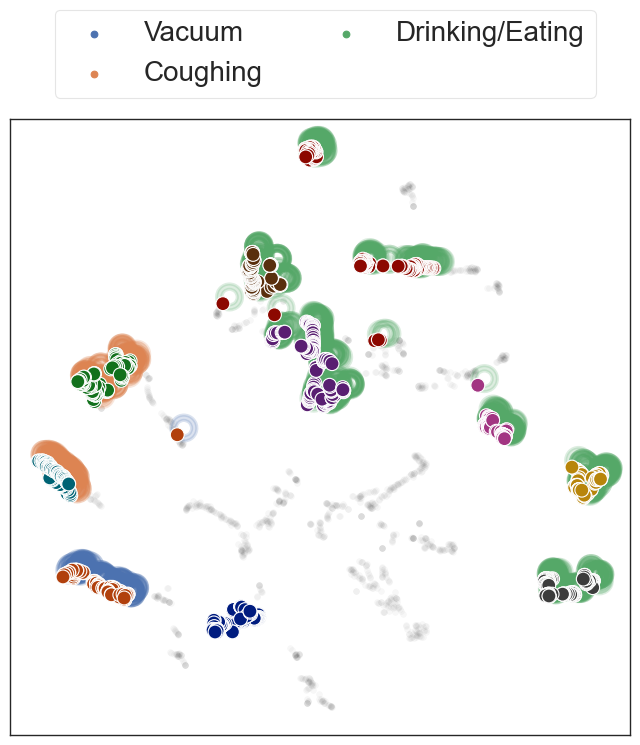

In [105]:
# get top sensor combinations at each sensor budget and show boxplot of accuracy across users
df_thermal_support = pd.read_csv("/Users/ppatida2/VAX/vax/HAR/evaluation/external/thermal_support_clusters.csv",
                                 index_col=0)
df_thermal_support.columns = ['instance_id', 'Activity', 'tsne_x', 'tsne_y', 'Cluster']
df_thermal_support.head()
import matplotlib.lines
df_thermal_support.loc[df_thermal_support.Activity.isin(['Drinking','Eating']),'Activity'] = 'Drinking/Eating'
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
df_thermal_support = df_thermal_support[~df_thermal_support.Activity.isin(['Knocking'])]
sns.scatterplot(data=df_thermal_support[df_thermal_support.Cluster < 0], x='tsne_x', y='tsne_y', color='k', alpha=0.03)
sns.scatterplot(data=df_thermal_support[(df_thermal_support.Cluster > 0)], x='tsne_x', y='tsne_y', hue='Activity',
                marker='$\circ$', ec='face', s=800, alpha=0.2)
ax.plot([], [], linestyle='', label='')
sns.scatterplot(data=df_thermal_support[df_thermal_support.Cluster >= 0], x='tsne_x', y='tsne_y', hue='Cluster', ax=ax,
                palette='dark', s=100)
ax.legend(fontsize=20)
#get legend and change stuff
handles, labels_legend = ax.get_legend_handles_labels()
for idx, h in enumerate(handles):
    if labels_legend[idx] not in activities + ['Eating', 'Drinking']:
        break
        # labels_legend[idx] = f'C{labels_legend[idx]}'
lg = ax.legend(handles[:idx], labels_legend[:idx], fontsize=20, ncol=2,bbox_to_anchor=(0.05,1.2))

# ax.legend.set_title("Clusters")
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_xlim(-25, 25)
# ax.set_ylim(-40, 20)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f'{plotting_dir}/thermal_support.png',bbox_inches='tight',dpi=300)

In [44]:
df_increase_det_rate = pd.read_csv('/Users/ppatida2/VAX/vax/HAR/evaluation/external/increase_in_detection_rate.csv')
df_increase_det_rate.columns = ['Activity','Models', 'Detection Rate']
df_increase_det_rate

,Activity,Models,Detection Rate
0,Baking,AV Only,0.303571
1,Blender,AV Only,0.803922
2,Chopping+Grating,AV Only,0.769231
3,CookingOnStove,AV Only,0.327869
4,Coughing,AV Only,0.862745
...,...,...,...
80,Shaver In Use,AV+All,0.781818
81,ToilerFlushing,AV+All,0.811321
82,Vacuum,AV+All,0.947368
83,Walking,AV+All,0.960784


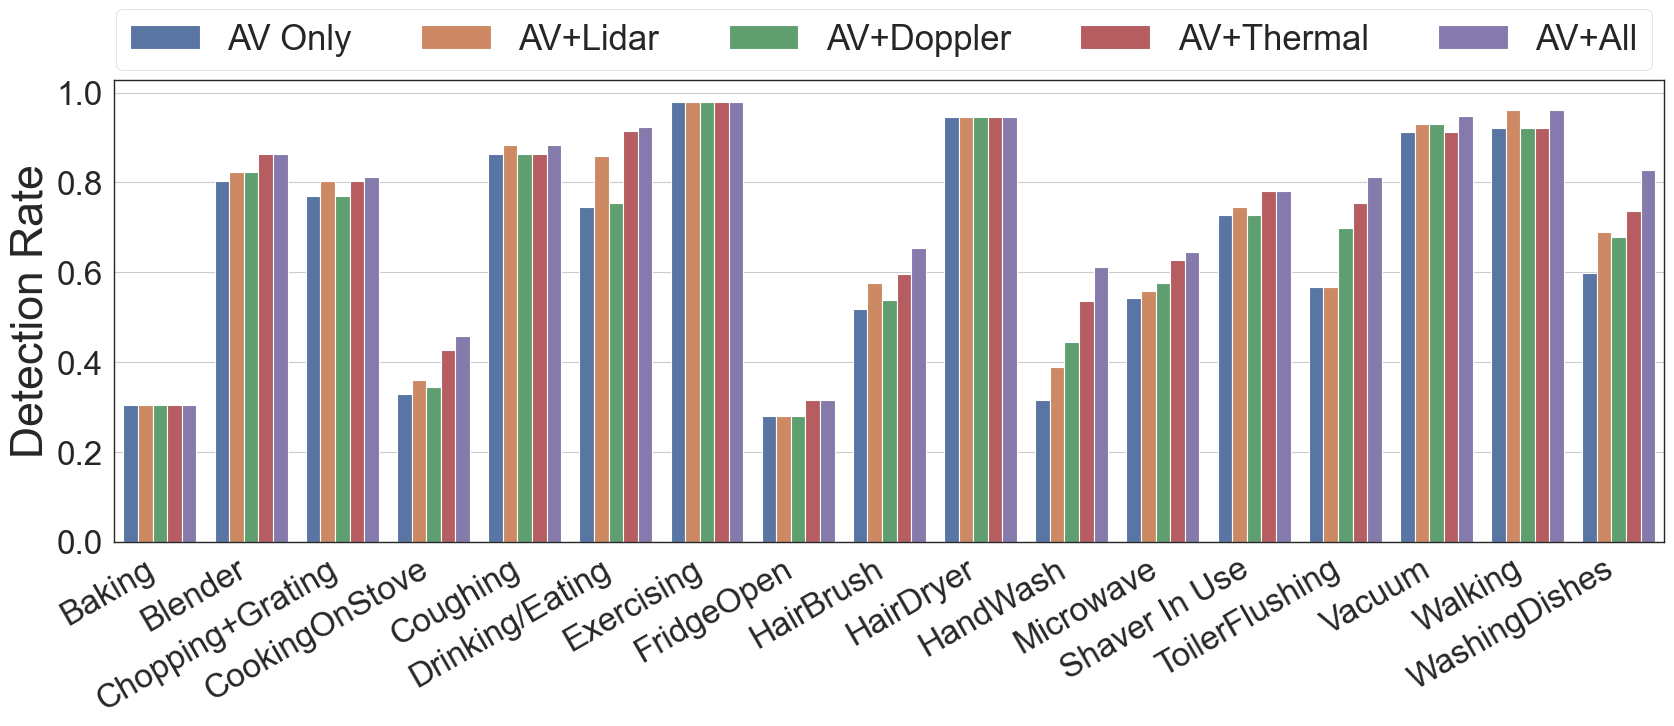

In [212]:
_,ax = plt.subplots(1,1,figsize=(20,6))
sns.barplot(data=df_increase_det_rate[~df_increase_det_rate.Activity.isin(['Knocking'])],x='Activity',y='Detection Rate',hue='Models')
handles, labels_legend = ax.get_legend_handles_labels()
plt.xticks(rotation=30,ha='right')
plt.xlabel("")
lg = ax.legend(handles, labels_legend, fontsize=25, ncol=5,bbox_to_anchor=(-0.01,1.19))
plt.savefig(f'{plotting_dir}/detection_rate.png',bbox_inches='tight',dpi=300)

# Home eval increase

In [4]:
df_home_inc = pd.read_csv("/Users/ppatida2/VAX/vax/HAR/evaluation/external/home_inc_nn_2.csv",index_col=0)
df_home_inc.accuracy = df_home_inc.accuracy*100
df_home_inc.detection =df_home_inc.detection*100
df_home_inc.head()

,training_count,id,accuracy,detection
0,9,"['P5', '']",86.585366,67.768595
1,9,"['P1', '']",73.134328,67.676768
2,9,"['P4', '']",92.727273,55.000000
3,9,"['P10', '']",92.592593,70.434783
4,9,"['P9', '']",100.000000,58.095238


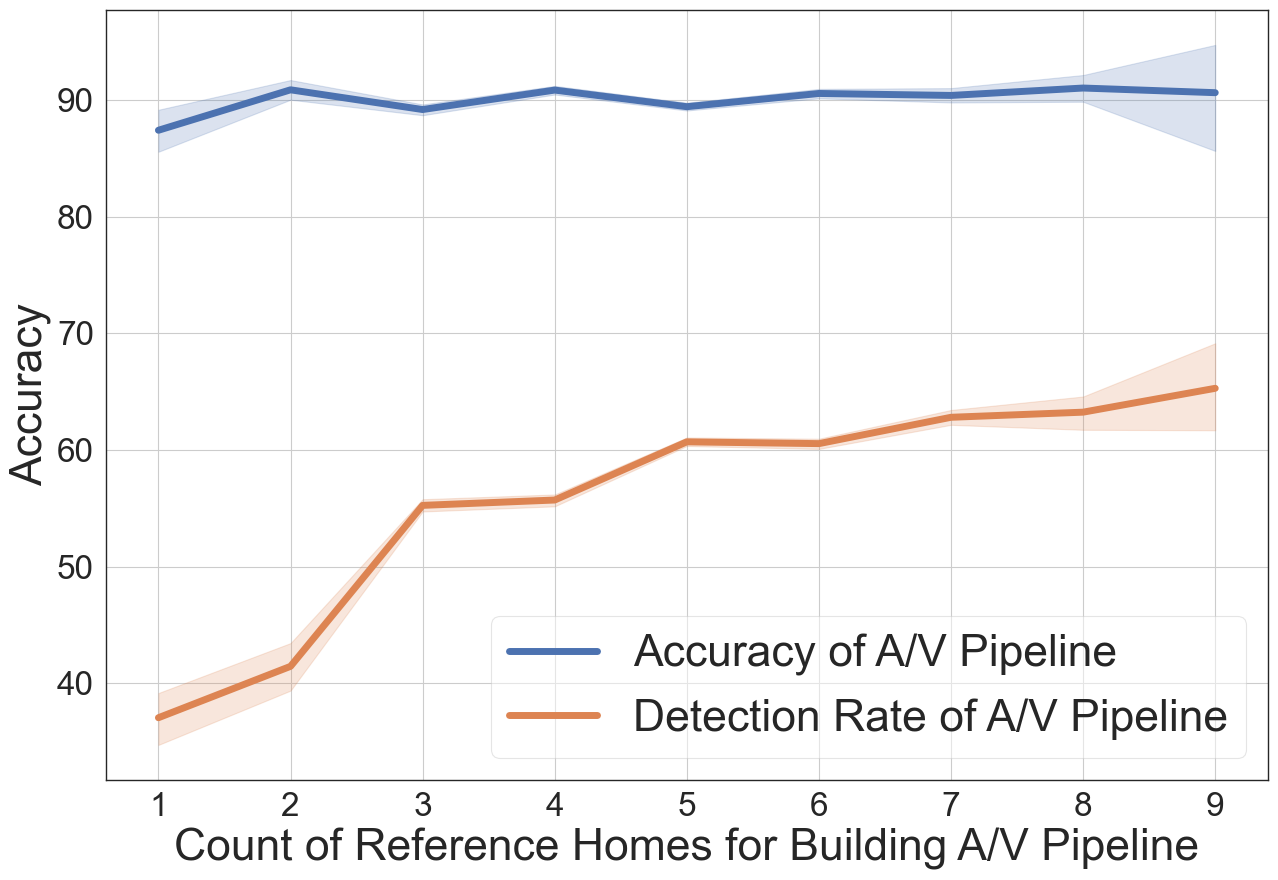

In [5]:
_,ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=df_home_inc, x='training_count',y='accuracy',ax=ax, label='Accuracy of A/V Pipeline')
sns.lineplot(data=df_home_inc, x='training_count',y='detection',ax=ax, label='Detection Rate of A/V Pipeline')
ax.set_ylabel("Metrics (%)")
# plt.ylim(bottom=0)
ax.legend(loc='lower right')
plt.xlabel("Count of Reference Homes for Building A/V Pipeline")
plt.ylabel("Accuracy")
plt.savefig(f"{plotting_dir}/e1_home_increase.png",dpi=300,bbox_inches='tight')

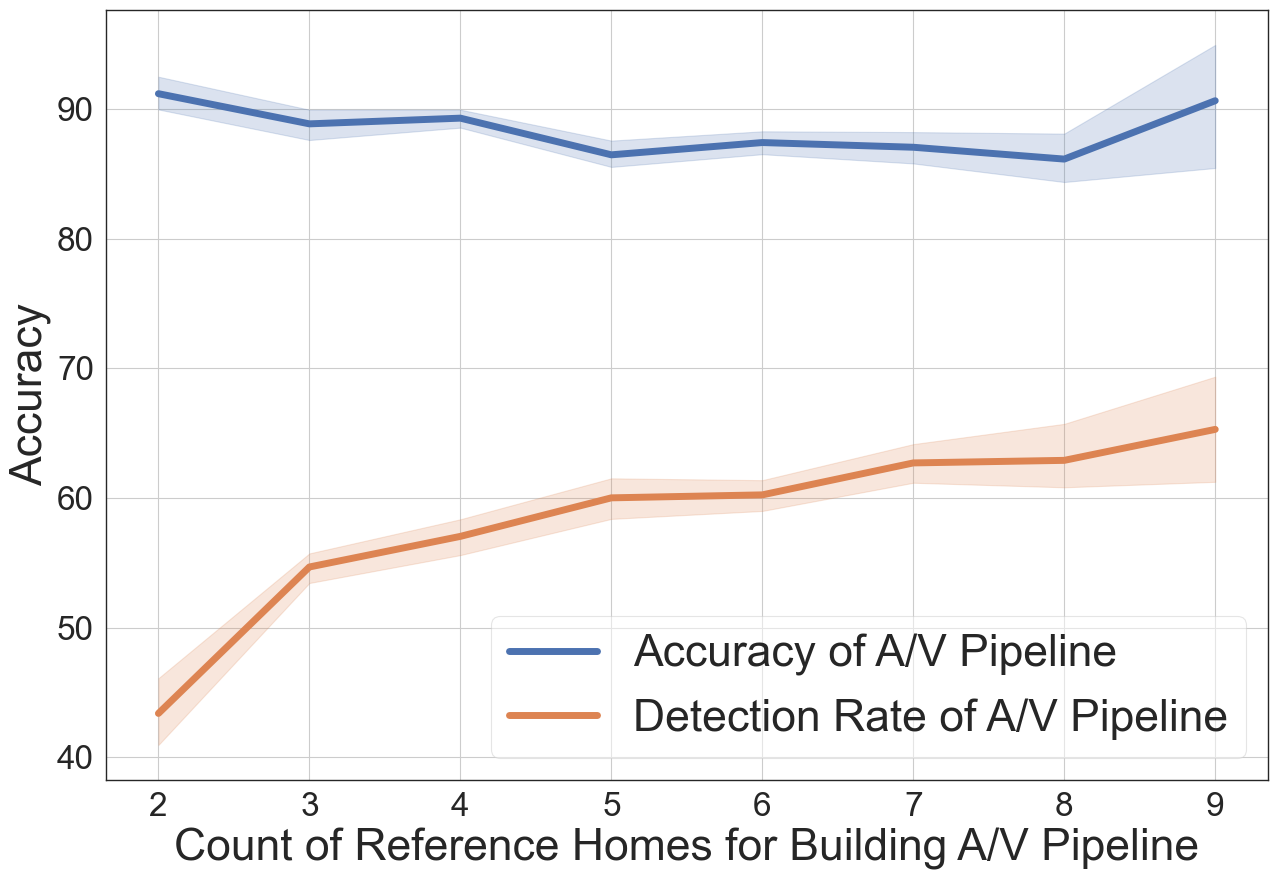

In [221]:
_,ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=df_home_inc, x='training_count',y='accuracy',ax=ax, label='Accuracy of A/V Pipeline')
sns.lineplot(data=df_home_inc, x='training_count',y='detection',ax=ax, label='Detection Rate of A/V Pipeline')
ax.set_ylabel("Metrics (%)")
# plt.ylim(bottom=0)
ax.legend(loc='lower right')
plt.xlabel("Count of Reference Homes for Building A/V Pipeline")
plt.ylabel("Accuracy")
plt.savefig(f"{plotting_dir}/e1_home_increase.png",dpi=300,bbox_inches='tight')

# final plot

In [126]:
csv_files = {
    # 'UserInputOnly All Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_baseline_all.csv',
    # 'UserInputOnly VAX Detected Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_baseline_detected.csv',
    'VAX All Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_all.csv',
    'VAX Detected Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_noinput_detected.csv',
    'VAX None Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_noinput_all.csv',
    'X-Only None Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_nn_noinput_all.csv',
    'X-Only VAX Detected Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_nn_noinput_detected.csv',
    'X-Only All Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_nn_all.csv',
}
df_all = None
for file_id in csv_files:
    df_file = pd.read_csv(csv_files[file_id])
    df_file = df_file[df_file.sensor=='best']
    df_file['correct_pred'] = (df_file['gt_label']==df_file['prediction'])
    df_file = df_file.groupby('user',as_index=False).agg({'correct_pred':lambda x: sum(x)/len(x)})
    df_file['file_id'] = file_id
    if 'UserInputOnly' in file_id:
        df_file['type'] = 'UserInputOnly'
    elif 'ReferenceHomes' in file_id:
        df_file['type'] = 'ReferenceHomes'
    else:
        df_file['type'] = 'VAX'
    if 'Detected' in file_id:
        df_file['run_type'] = 'Activities Detected in VAX'
    if 'All' in file_id:
        df_file['run_type'] = 'All Activities'
    if 'None' in file_id:
        df_file['run_type'] = 'All Activities- No Input'
    if df_all is None:
        df_all = df_file.copy(deep=True)
    else:
        df_all = pd.concat([df_all,df_file])

df_user_input_0 = {'user':'P1',
                   'correct_pred':0,
                   'file_id':'UserInputOnly All Activities- No Input',
                   'type':'UserInputOnly',
                   'run_type':'All Activities- No Input',
                   'pipeline':'UserInputOnly All Activities- No Input'}
df_all = df_all.append(df_user_input_0,ignore_index=True)

/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_78329/609227368.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df_user_input_0,ignore_index=True)


In [127]:
df_all['pipeline'] = df_all['file_id']
df_all['correct_pred'] = df_all['correct_pred']*100

In [128]:
type_sorter = ['UserInputOnly','ReferenceHomes','VAX']
run_type_sorter = ['All Activities- No Input','Activities Detected in VAX','All Activities']
df_all['sort_key'] = df_all.apply(lambda row: (10*run_type_sorter.index(row['run_type'])) + type_sorter.index(row['type']),axis=1).astype(int)
df_all.sort_values(by=['sort_key'])

,user,correct_pred,file_id,type,run_type,pipeline,sort_key
60,P1,0.000000,UserInputOnly All Activities- No Input,UserInputOnly,All Activities- No Input,UserInputOnly All Activities- No Input,0
22,P2,72.164948,VAX None Activities,VAX,All Activities- No Input,VAX None Activities,2
23,P3,76.923077,VAX None Activities,VAX,All Activities- No Input,VAX None Activities,2
24,P4,64.948454,VAX None Activities,VAX,All Activities- No Input,VAX None Activities,2
25,P5,73.275862,VAX None Activities,VAX,All Activities- No Input,VAX None Activities,2
...,...,...,...,...,...,...,...
4,P4,70.833333,VAX All Activities,VAX,All Activities,VAX All Activities,22
5,P5,73.913043,VAX All Activities,VAX,All Activities,VAX All Activities,22
6,P6,85.416667,VAX All Activities,VAX,All Activities,VAX All Activities,22
8,P8,90.677966,VAX All Activities,VAX,All Activities,VAX All Activities,22


In [60]:
type_sorter.index('UserInputOnly')

0

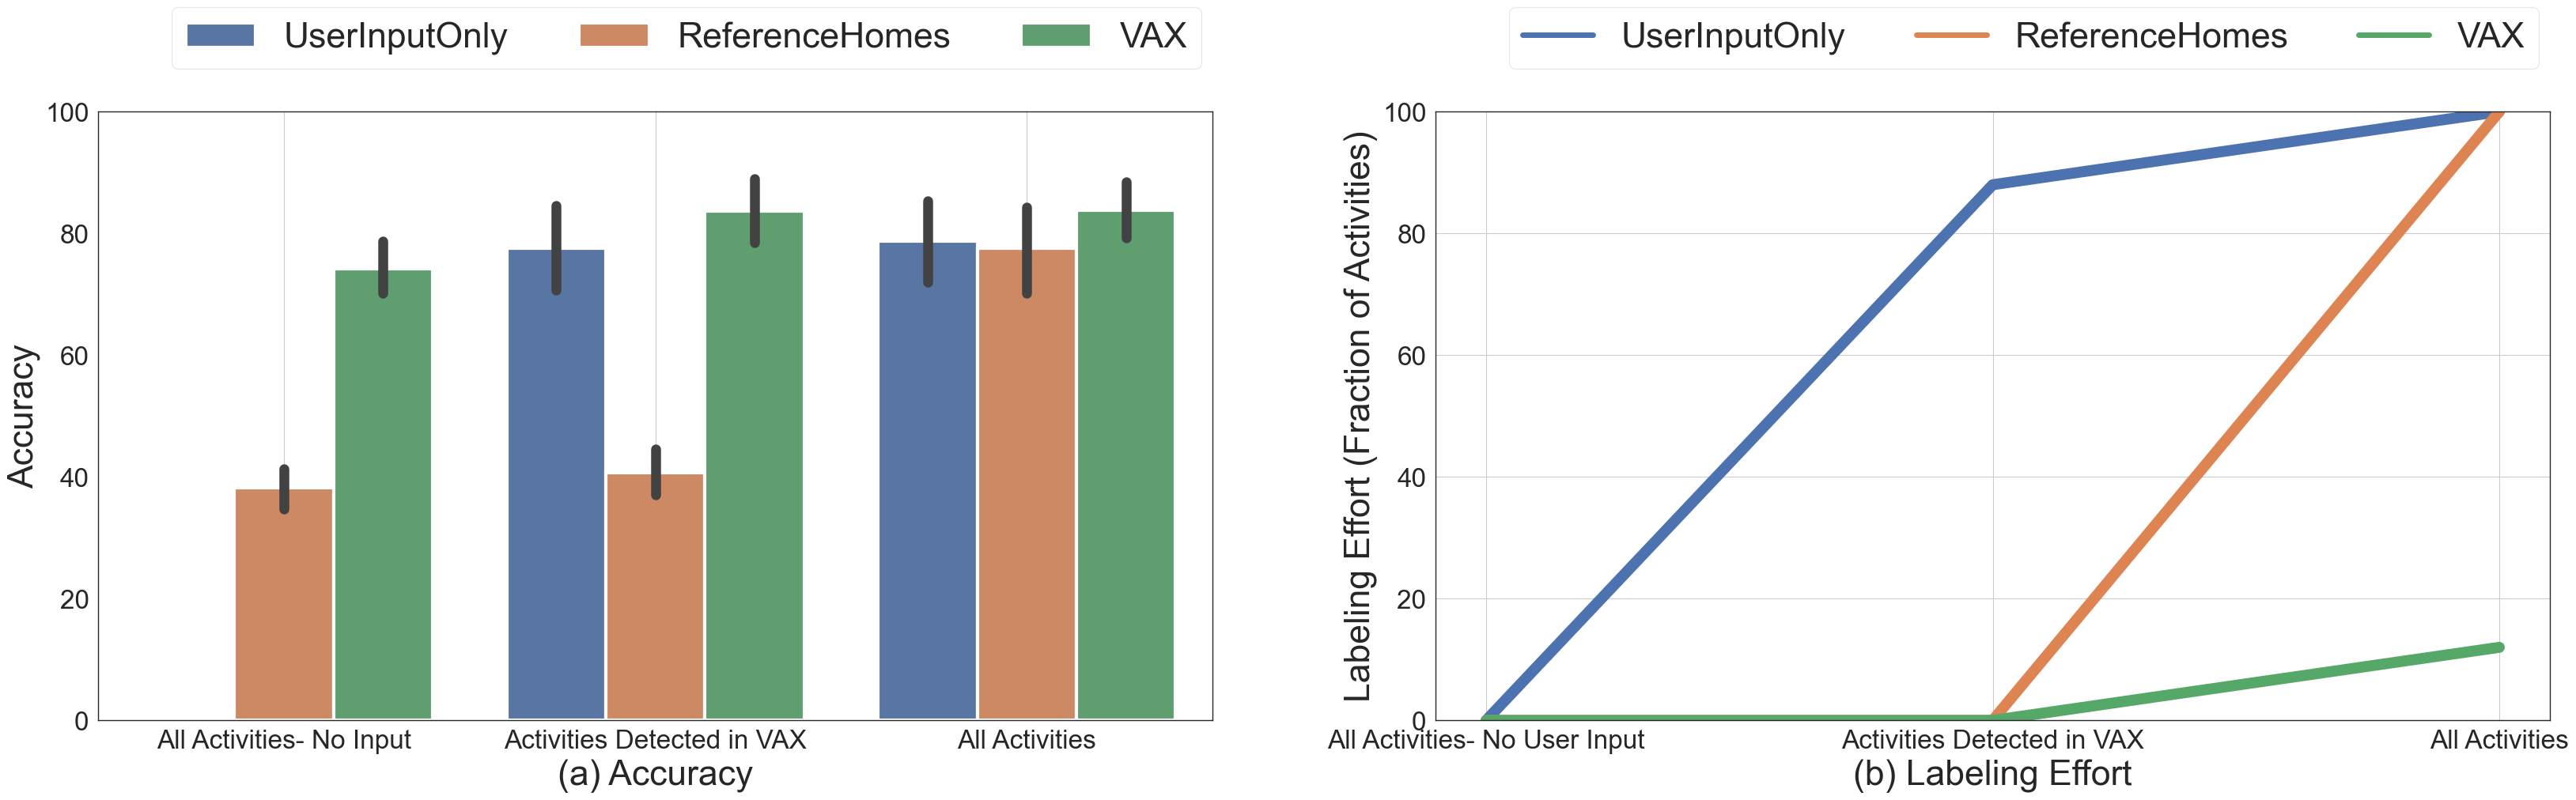

In [113]:
_,axn = plt.subplots(1,2,figsize=(40,10))
ax=axn[0]
sns.barplot(data=df_all, x='run_type',y='correct_pred',hue='type',ax=ax,order=run_type_sorter, hue_order=type_sorter,linewidth=3)
ax.set_xlabel("(a) Accuracy")
ax.set_ylabel("Accuracy")
ax.legend(ncol=3, bbox_to_anchor=(0.05, 1.2))
ax.grid()
ax.set_ylim(0,100)

ax2 = axn[1]
sns.lineplot(data=labeling_effort, x='run_type',y='Labelling Effort',color='k',hue='type',ax=ax2,linewidth=10)
ax2.set_ylabel("Labeling Effort (Fraction of Activities)")
ax2.set_xlabel("(b) Labeling Effort")
ax2.legend(ncol=3, bbox_to_anchor=(0.05, 1.2))
# ax2.legend(title="Labeling Effort (Right Axis)",bbox_to_anchor=(1.1, .4))
ax2.set_ylim(0,100)
plt.savefig(f"{plotting_dir}/vax_baseline_compare.png",dpi=300, bbox_inches='tight')
# ax2.get_legend().remove()

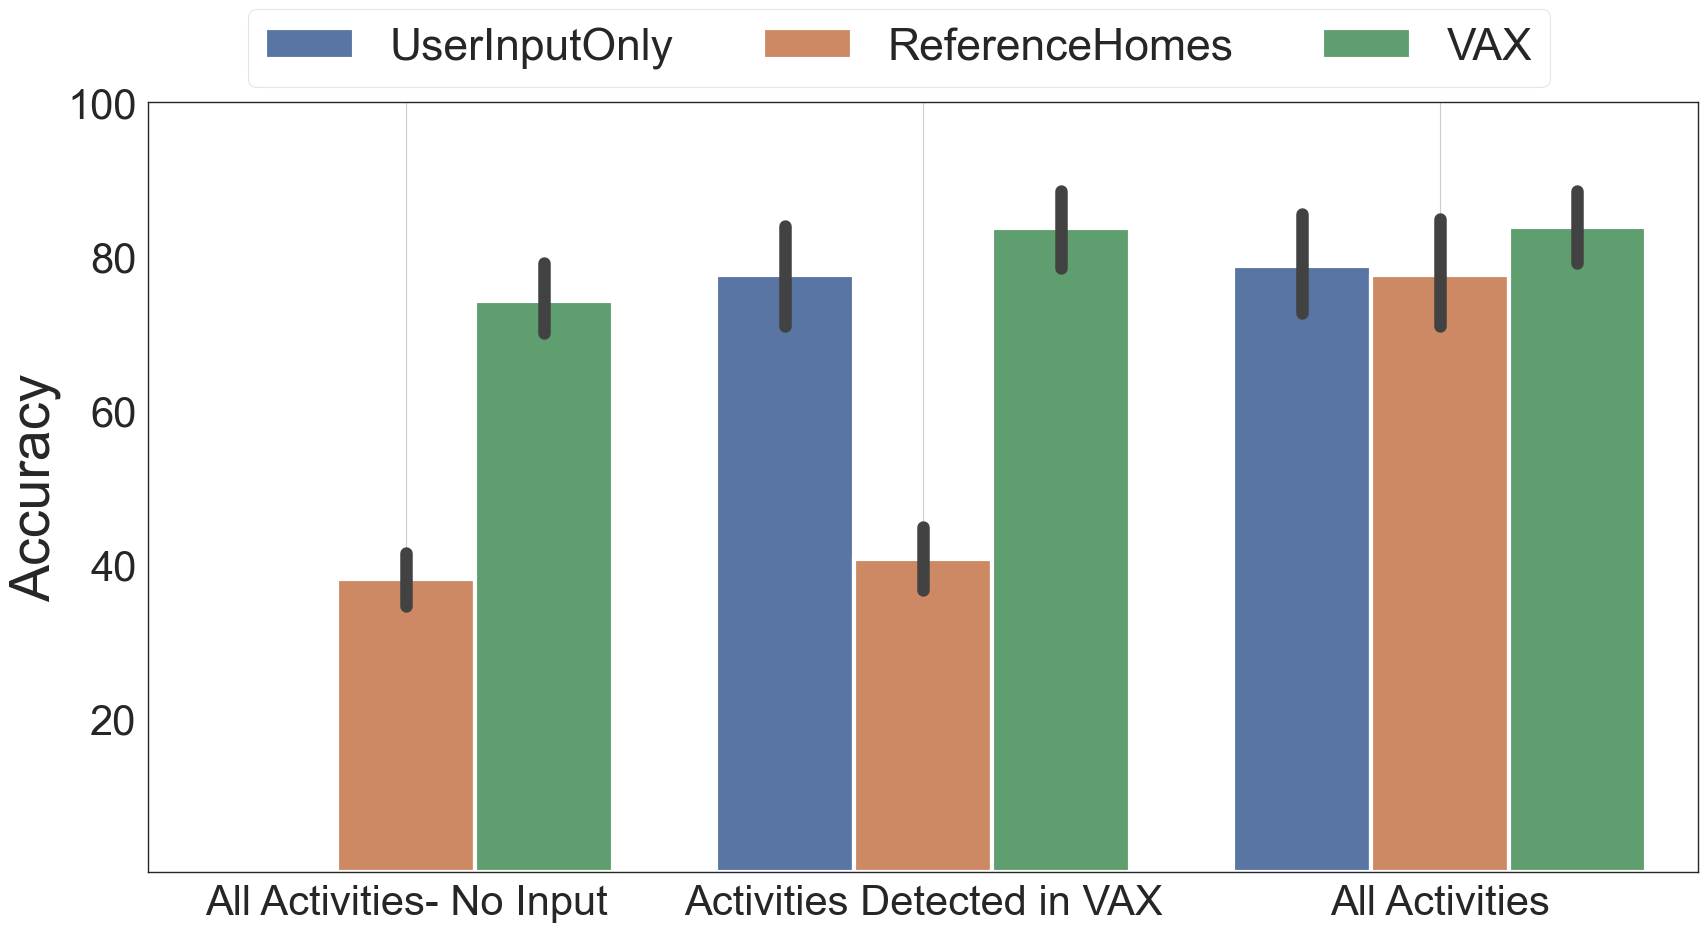

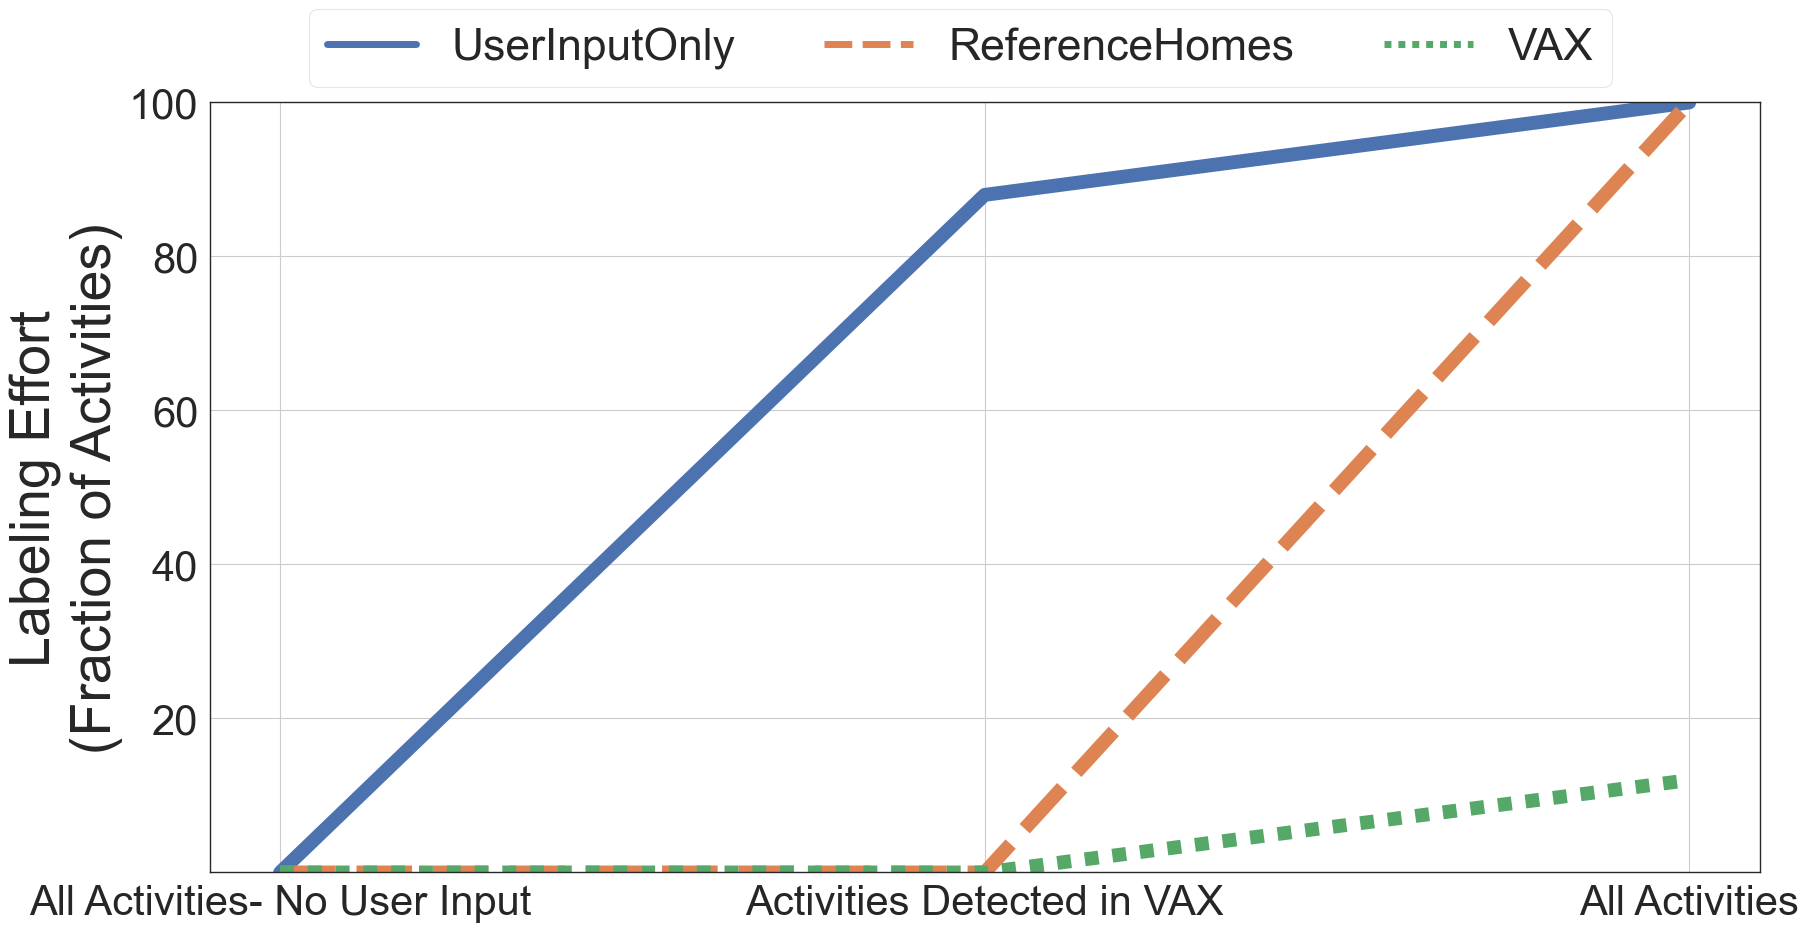

In [125]:
_,ax = plt.subplots(1,1,figsize=(20,10))
sns.barplot(data=df_all, x='run_type',y='correct_pred',hue='type',ax=ax,order=run_type_sorter, hue_order=type_sorter,linewidth=3)
ax.set_xlabel("")
ax.set_ylabel("Accuracy",fontsize=40)
plt.yticks(range(20,110,20), range(20,110,20), fontsize=30)
plt.xticks(fontsize=30)
ax.legend(ncol=3, bbox_to_anchor=(0.05, 1.15))
ax.grid()
ax.set_ylim(0,100)
plt.savefig(f"{plotting_dir}/vax_baseline_acc_compare.png",dpi=300, bbox_inches='tight')


_,ax2 = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data=labeling_effort, x='run_type',y='Labelling Effort',color='k',hue='type', style='type',ax=ax2,linewidth=10)
ax2.set_ylabel("Labeling Effort\n(Fraction of Activities)",fontsize=40)
ax2.set_xlabel("")
plt.yticks(range(20,110,20), range(20,110,20), fontsize=30)
plt.xticks(fontsize=30)
ax2.legend(ncol=3, bbox_to_anchor=(0.05, 1.15))
# ax2.legend(title="Labeling Effort (Right Axis)",bbox_to_anchor=(1.1, .4))
ax2.set_ylim(0,100)
plt.savefig(f"{plotting_dir}/vax_baseline_effort_compare.png",dpi=300, bbox_inches='tight')
# ax2.get_legend().remove()

In [54]:
labeling_effort = pd.DataFrame([('All Activities- No User Input','UserInputOnly',0), ('All Activities- No User Input','ReferenceHomes',0), ('All Activities- No User Input','VAX',0),
                                ('Activities Detected in VAX','UserInputOnly',88), ('Activities Detected in VAX','ReferenceHomes',0),('Activities Detected in VAX','VAX',0),
                                ('All Activities','UserInputOnly',100), ('All Activities','ReferenceHomes',100), ('All Activities','VAX',12)], columns=['run_type','type','Labelling Effort'])
labeling_effort

,run_type,type,Labelling Effort
0,All Activities- No User Input,UserInputOnly,0
1,All Activities- No User Input,ReferenceHomes,0
2,All Activities- No User Input,VAX,0
3,Activities Detected in VAX,UserInputOnly,88
4,Activities Detected in VAX,ReferenceHomes,0
5,Activities Detected in VAX,VAX,0
6,All Activities,UserInputOnly,100
7,All Activities,ReferenceHomes,100
8,All Activities,VAX,12


# New baseline comparison graph : No Input

In [240]:
csv_files = {
    # 'VAX All Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_all.csv',
    'VAX Detected Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_noinput_detected.csv',
    'VAX All Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_noinput_all.csv',
    'X-Only (pre-trained) All Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_nn_noinput_all.csv',
    'X-Only (pre-trained) VAX Detected Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_nn_noinput_detected.csv',
    # 'X-Only All Activities':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_nn_all.csv',
}
df_all = None
for file_id in csv_files:
    df_file = pd.read_csv(csv_files[file_id])
    df_file = df_file[df_file.sensor=='best']
    df_file['correct_pred'] = (df_file['gt_label']==df_file['prediction'])
    df_file = df_file.groupby('user',as_index=False).agg({'correct_pred':lambda x: sum(x)/len(x)})
    df_file['file_id'] = file_id
    if 'X-Only' in file_id:
        df_file['type'] = 'X-Only (pre-trained)'
    else:
        df_file['type'] = 'VAX'
    if 'Detected' in file_id:
        df_file['run_type'] = 'Activities Detected in VAX'
    if 'All' in file_id:
        df_file['run_type'] = 'All Activities'
    # if 'None' in file_id:
    #     df_file['run_type'] = 'All Activities- No Input'
    if df_all is None:
        df_all = df_file.copy(deep=True)
    else:
        df_all = pd.concat([df_all,df_file])


In [241]:
df_all['pipeline'] = df_all['file_id']
df_all['correct_pred'] = df_all['correct_pred']*100
run_type_sorter = ['All Activities', 'Activities Detected in VAX']
type_sorter = ['X-Only (pre-trained)', 'VAX']
df_all['sort_key'] = df_all.apply(lambda row: (10*run_type_sorter.index(row['run_type'])) + type_sorter.index(row['type']),axis=1).astype(int)
df_all.sort_values(by=['sort_key'])

,user,correct_pred,file_id,type,run_type,pipeline,sort_key
7,P7,29.896907,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
5,P5,37.068966,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
4,P4,37.113402,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
3,P3,42.307692,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
2,P2,40.206186,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
1,P10,28.571429,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
0,P1,45.833333,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
8,P8,40.833333,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
9,P9,44.117647,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0
6,P6,35.714286,X-Only (pre-trained) All Activities,X-Only (pre-trained),All Activities,X-Only (pre-trained) All Activities,0


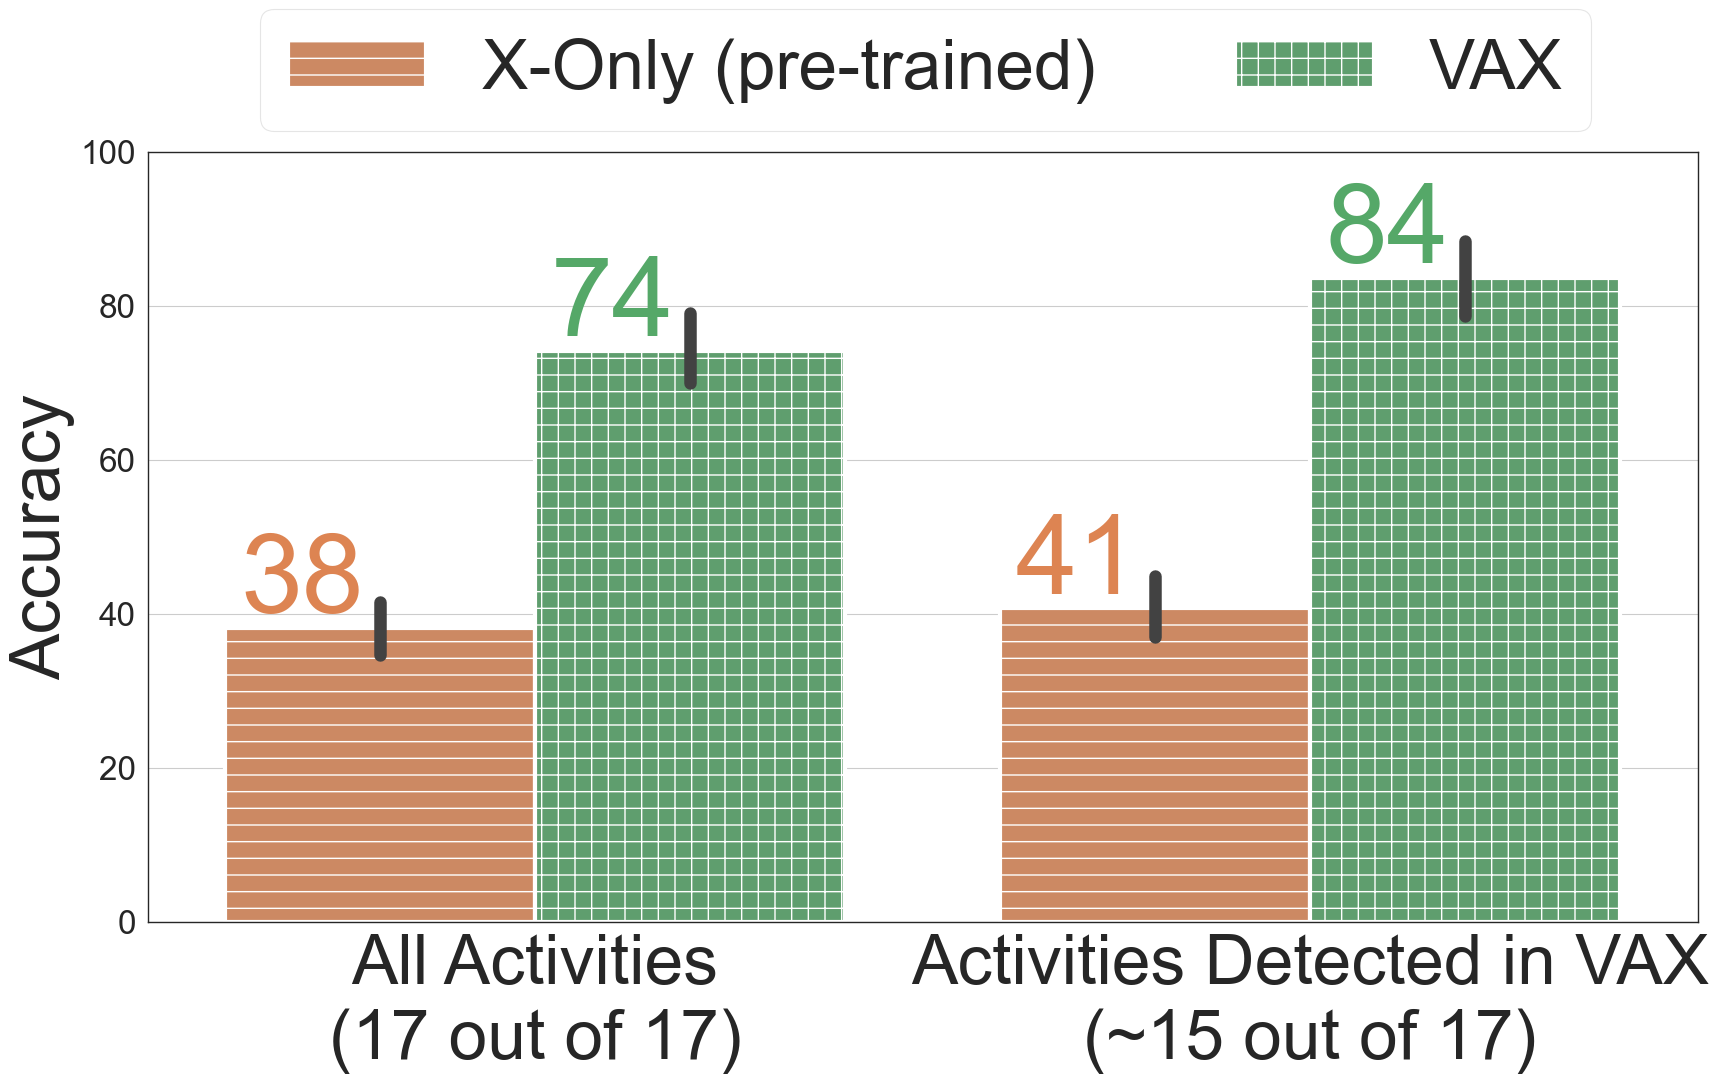

In [243]:
plt.figure(figsize=(20,10))
colors = ['#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']
ax = sns.barplot(data=df_all, x='run_type', y='correct_pred', hue='type', order=run_type_sorter,
            hue_order=type_sorter, linewidth=3, palette=colors)
plt.ylim(0,100)
# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']
for i,p in enumerate(ax.patches):
    height = p.get_height()
    width = p.get_width()
    p.set_hatch(hatches[i//2])

    # adding text to each bar
    ax.text(x = p.get_x()+0.1, # x-coordinate position of data label, padded to left of bar
            y = p.get_y()+height+2, # # y-coordinate position of data label, padded to be in the middle of the bar
            s = "{:.0f}".format(height), # data label, formatted to ignore decimals
                     ha = "center", size=80, color=colors[i//2]) # sets vertical alignment (va) to center
plt.legend(ncol=2, bbox_to_anchor=(0.05, 1.23),fontsize=50)
plt.ylabel('Accuracy',fontsize=50)
plt.xlabel('')
plt.xticks((0,1),('All Activities\n(17 out of 17)','Activities Detected in VAX\n(~15 out of 17)'),ha='center', fontsize=50)
plt.savefig(f"{plotting_dir}/vax_baseline_acc_no_input.png", dpi=300, bbox_inches='tight')

# New baseline comparison graph : User Input

In [244]:
csv_files = {
    'Baseline':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_baseline_all.csv',
    'VAX':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_vax_all.csv',
    'X-Only':'/Users/ppatida2/VAX/vax/HAR/privacy_sensors/Notebooks/results/results_v10_nn_all.csv',
}
df_all = None
for file_id in csv_files:
    df_file = pd.read_csv(csv_files[file_id])
    df_file = df_file[df_file.sensor=='best']
    df_file['correct_pred'] = (df_file['gt_label']==df_file['prediction'])
    df_file = df_file.groupby('user',as_index=False).agg({'correct_pred':lambda x: sum(x)/len(x)})
    df_file['file_id'] = file_id
    if 'X-Only' in file_id:
        df_file['type'] = 'X-Only'
    elif 'Baseline' in file_id:
        df_file['type'] = 'Baseline'
    else:
        df_file['type'] = 'VAX'
    if 'Detected' in file_id:
        df_file['run_type'] = 'Activities Detected in VAX'
    if 'All' in file_id:
        df_file['run_type'] = 'All Activities'
    # if 'None' in file_id:
    #     df_file['run_type'] = 'All Activities- No Input'
    if df_all is None:
        df_all = df_file.copy(deep=True)
    else:
        df_all = pd.concat([df_all,df_file])


In [245]:
df_all['pipeline'] = df_all['file_id']
df_all['correct_pred'] = df_all['correct_pred']*100
type_sorter = ['Baseline', 'X-Only', 'VAX']
df_all['sort_key'] = df_all.apply(lambda row: + type_sorter.index(row['type']),axis=1).astype(int)
df_all.sort_values(by=['sort_key'])

,user,correct_pred,file_id,type,pipeline,sort_key
0,P1,80.487805,Baseline,Baseline,Baseline,0
9,P9,84.883721,Baseline,Baseline,Baseline,0
7,P7,81.481481,Baseline,Baseline,Baseline,0
6,P6,70.370370,Baseline,Baseline,Baseline,0
5,P5,65.000000,Baseline,Baseline,Baseline,0
8,P8,93.203883,Baseline,Baseline,Baseline,0
3,P3,89.655172,Baseline,Baseline,Baseline,0
2,P2,65.432099,Baseline,Baseline,Baseline,0
1,P10,90.625000,Baseline,Baseline,Baseline,0
4,P4,66.666667,Baseline,Baseline,Baseline,0


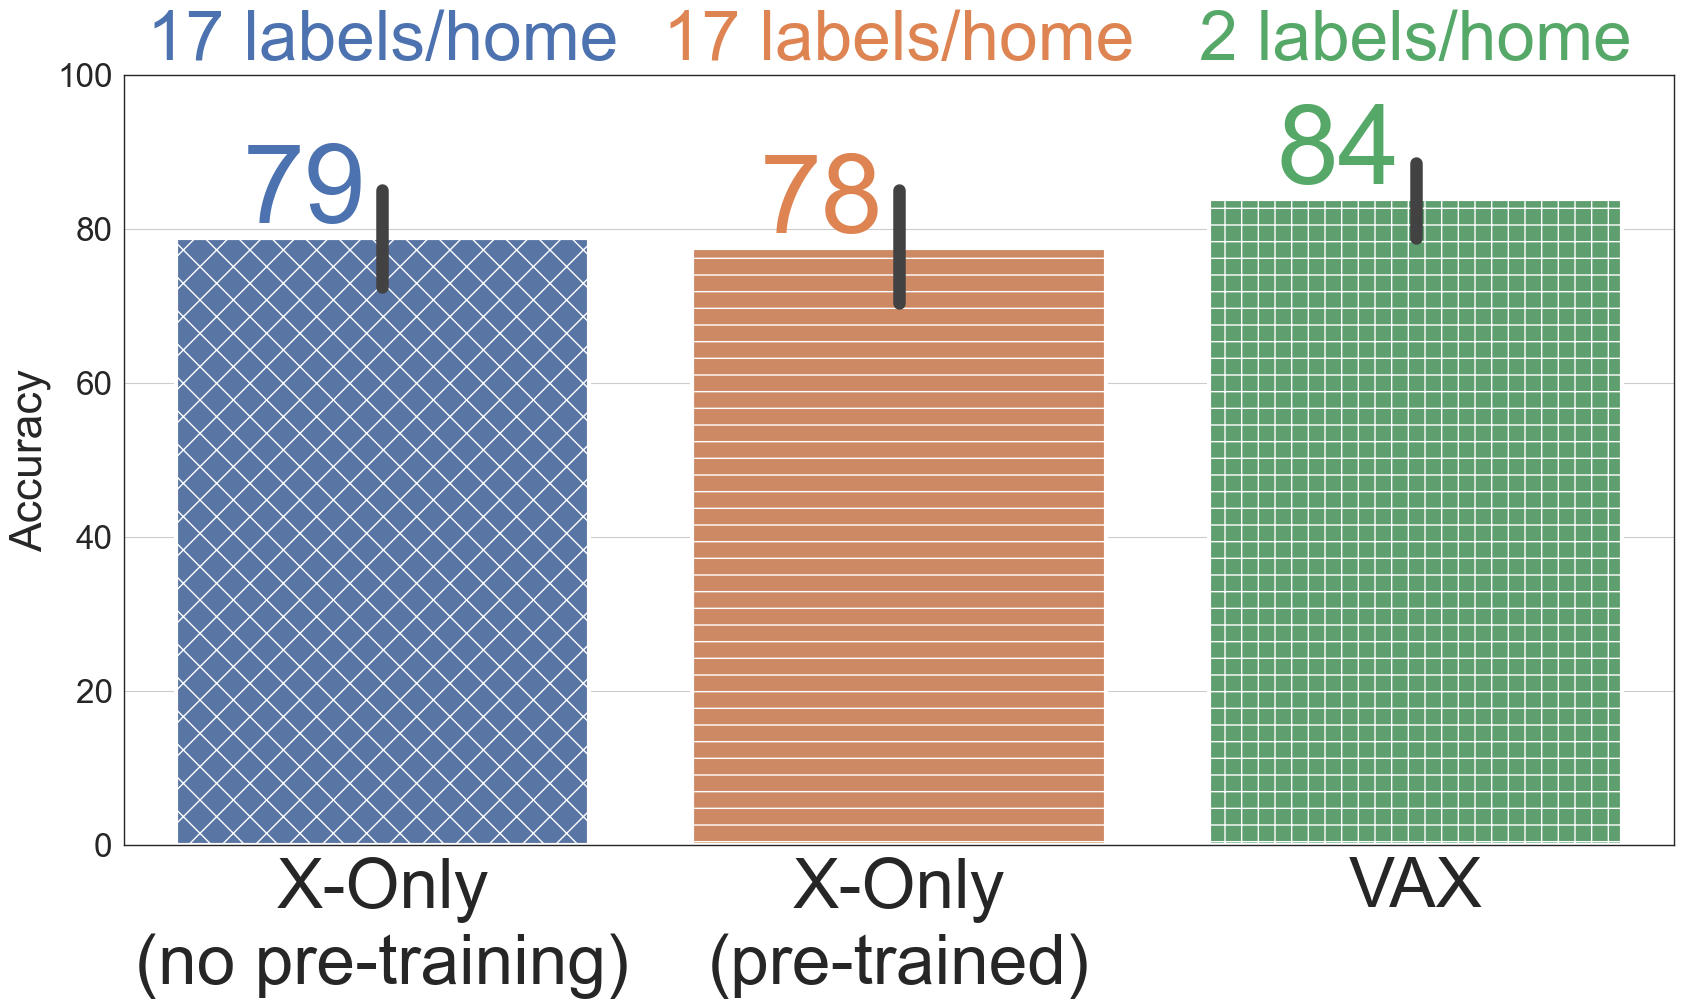

In [247]:
plt.figure(figsize=(20,10))
colors = ['#4c72b0', '#dd8452','#55a868'  , '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']
ax = sns.barplot(data=df_all, x='type', y='correct_pred', order=type_sorter,linewidth=3, palette=colors)
labels_text = ["17 labels/home", "17 labels/home", "2 labels/home"]
plt.ylim(0,100)
# Define some hatches
hatches = ['x', '-', '+', '\\', '*', 'o']
for i,p in enumerate(ax.patches):
    height = p.get_height()
    width = p.get_width()
    p.set_hatch(hatches[i])

    # adding text to each bar
    ax.text(x = p.get_x()+0.25, # x-coordinate position of data label, padded to left of bar
            y = p.get_y()+height+2, # # y-coordinate position of data label, padded to be in the middle of the bar
            s = "{:.0f}".format(height), # data label, formatted to ignore decimals
                     ha = "center", size=80, color=colors[i]) # sets vertical alignment (va) to center
    ax.text(x = p.get_x()+0.4, # x-coordinate position of data label, padded to left of bar
        y = p.get_y()+102, # # y-coordinate position of data label, padded to be in the middle of the bar
        s = labels_text[i], # data label, formatted to ignore decimals
         ha = "center", size=50, color=colors[i]) # sets vertical alignment (va) to center
# plt.legend(('Baseline','X-Only','VAX'), ncol=3, bbox_to_anchor=(0.18, 1.5),fontsize=50)
plt.ylabel('Accuracy')
plt.xlabel('')
plt.xticks((0,1,2),('X-Only\n(no pre-training)','X-Only\n(pre-trained)','VAX'),ha='center', fontsize=50)
plt.savefig(f"{plotting_dir}/vax_baseline_acc_user_input.png", dpi=300, bbox_inches='tight')